In [1]:
library(dplyr)
library(tidyverse)
library(TTR)
library(quantmod)
library(devtools)
#install_github("kochiuyu/CandleStickPattern")
library(CandleStickPattern)
library(xts)
library(stringr)
library(distributional)
library(forecast)
library(rpart)
library(rpart.plot)
library(shadowtext)
library(ggfortify)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: usethis

Registered S3 metho

In [2]:
# Source of data: Barchart.com
# 30 minute candlesticks for SPY from 05-06-08 to 11-02-22
# Includes Time, Open, High, Low, Close, $ Change, % Change, and Volume variables

spy <- read.csv('~/Downloads/spy30min_050608_110222.csv')
head(spy)

Time             Open     High   Low     Last    Change X.Chg  Volume  
1 11/02/2022 15:30 377.0740 377.54 374.760 374.790 -2.300 -0.61% 20177748
2 11/02/2022 15:00 380.5150 383.19 376.250 377.090 -3.400 -0.89% 11783992
3 11/02/2022 14:30 387.8800 388.63 378.960 380.490 -7.380 -1.90% 20604567
4 11/02/2022 14:00 383.3281 388.00 382.090 387.870  4.545 +1.19% 14339183
5 11/02/2022 13:30 382.1500 383.94 382.055 383.325  1.165 +0.30%  3379006
6 11/02/2022 13:00 382.4800 382.51 382.000 382.160 -0.320 -0.08%  1552043

In [3]:
# Reversing the rows so data is in chronological order
spy_reversed <- as.data.frame(spy %>% apply(2, rev))

# Rename Last to Close bc it is more commonly referred to as such
spy_reversed <- spy_reversed  %>% rename(Close = Last)

# Numerical values are correctly designated
spy_reversed$Open <- as.numeric(spy_reversed$Open)
spy_reversed$High <- as.numeric(spy_reversed$High)
spy_reversed$Low <- as.numeric(spy_reversed$Low)
spy_reversed$Close <- as.numeric(spy_reversed$Close)
spy_reversed$Change <- as.numeric(spy_reversed$Change)
spy_reversed$Volume <- as.numeric(spy_reversed$Volume)

# Use 'Time' Variable as rownames -- more appropriate for time series data
rownames(spy_reversed) <- as.POSIXct(spy_reversed$Time, format = '%m/%d/%Y %H:%M')

# Remove candles with no volume, which only occur on half-days due to holidays -- removes incomplete data
spy_reversed <- spy_reversed  %>% filter(Volume>0)

# Create a dollar volume variable 'VolumeUSD' that is the median price of candle times the volume to better
# represent and comapre the volume across various price levels
spy_reversed <- spy_reversed  %>% mutate(VolumeUSD = Volume*((High+Low)/2))

# Add EMA3 variable that takes the Exponential Moving Average across last 3 candles
spy_reversed$EMA3 <- round(TTR::EMA(spy_reversed$Close, n =3), 4)

dim(spy_reversed)
head(spy_reversed)

[1] 47298    10

Time             Open   High   Low    Close  Change X.Chg 
2008-05-06 09:30:00 05/06/2008 09:30 140.01 140.11 139.69 139.95 -0.84  -0.60%
2008-05-06 10:00:00 05/06/2008 10:00 139.96 140.44 139.85 140.21  0.26  +0.19%
2008-05-06 10:30:00 05/06/2008 10:30 140.20 140.62 140.02 140.60  0.39  +0.28%
2008-05-06 11:00:00 05/06/2008 11:00 140.61 140.78 140.42 140.54 -0.06  -0.04%
2008-05-06 11:30:00 05/06/2008 11:30 140.54 140.83 140.40 140.82  0.28  +0.20%
2008-05-06 12:00:00 05/06/2008 12:00 140.83 141.50 140.83 141.34  0.52  +0.37%
                    Volume   VolumeUSD  EMA3    
2008-05-06 09:30:00 15781900 2207887810       NA
2008-05-06 10:00:00 12615800 1768041291       NA
2008-05-06 10:30:00 10506800 1474314176 140.2533
2008-05-06 11:00:00 12186700 1713450020 140.3967
2008-05-06 11:30:00  6367200  895323828 140.6083
2008-05-06 12:00:00 15039800 2123093367 140.9742

In [4]:
# Create new dataframe solely for plotting the candles
spy1 <- spy_reversed
rownames(spy1) <- as.POSIXct(spy1$Time, format = '%m/%d/%Y %H:%M')
spy1 <- spy1 %>% dplyr::select(c(Open,High,Low,Close,Volume))

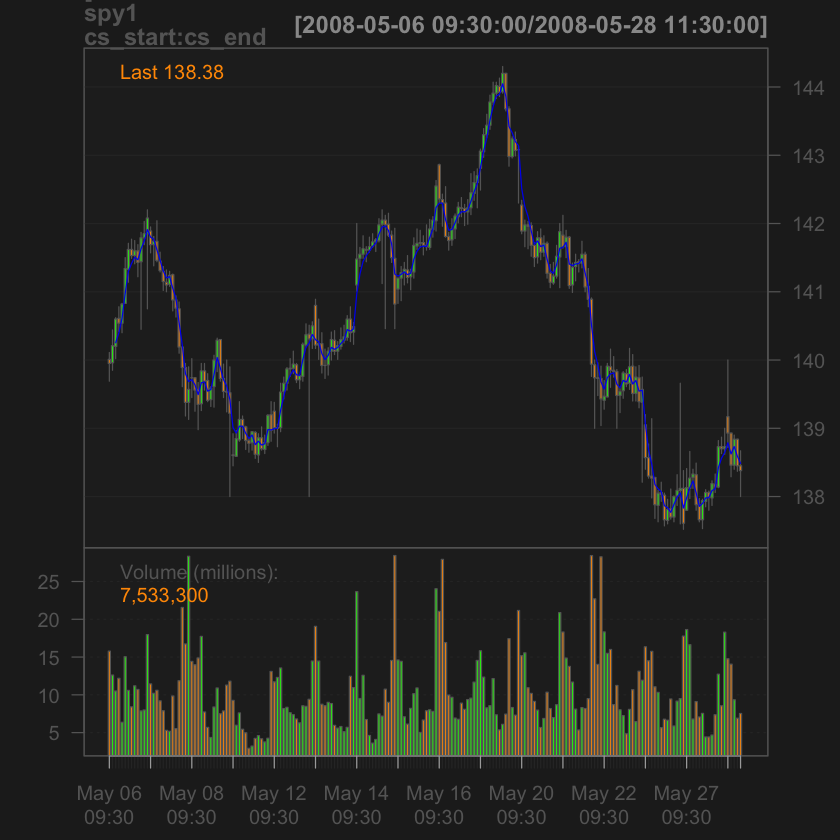

In [5]:
cs_start=1
cs_end=200

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo())) 

In [6]:
# Create variables for Local Min/Max for candles where the EMA3 is less than/ greater than or equal to
# the EMA3 of 2 candles behind and 2 candles ahead
spy_reversed <- spy_reversed  %>% mutate(Local_Min = ifelse(EMA3<=lag(EMA3,n=1L) & EMA3<=lag(EMA3,n=2L) &
                                                                EMA3<=lead(EMA3,n=1L) & EMA3<=lead(EMA3,n=2L),
                                                                1, 0))  %>% 
                                mutate(Local_Max = ifelse(EMA3>=lag(EMA3,n=1L) & EMA3>=lag(EMA3,n=2L) &
                                                                EMA3>=lead(EMA3,n=1L) & EMA3>=lead(EMA3,n=2L),
                                                                1, 0))
tail(spy_reversed,10)

Time             Open     High     Low     Close   Change
2022-11-02 11:00:00 11/02/2022 11:00 382.7600 383.0700 382.270 382.640 -0.110
2022-11-02 11:30:00 11/02/2022 11:30 382.6500 383.1021 382.430 382.710  0.070
2022-11-02 12:00:00 11/02/2022 12:00 382.7000 382.8850 381.750 381.755 -0.955
2022-11-02 12:30:00 11/02/2022 12:30 381.7571 382.6901 381.390 382.480  0.725
2022-11-02 13:00:00 11/02/2022 13:00 382.4800 382.5100 382.000 382.160 -0.320
2022-11-02 13:30:00 11/02/2022 13:30 382.1500 383.9400 382.055 383.325  1.165
2022-11-02 14:00:00 11/02/2022 14:00 383.3281 388.0000 382.090 387.870  4.545
2022-11-02 14:30:00 11/02/2022 14:30 387.8800 388.6300 378.960 380.490 -7.380
2022-11-02 15:00:00 11/02/2022 15:00 380.5150 383.1900 376.250 377.090 -3.400
2022-11-02 15:30:00 11/02/2022 15:30 377.0740 377.5400 374.760 374.790 -2.300
                    X.Chg  Volume   VolumeUSD  EMA3     Local_Min Local_Max
2022-11-02 11:00:00 -0.03%  1813793  694084167 382.7416  0        0        
2022-11-02 11:30:00 +0.02%  1774407  679182758 382.7258  0        0        
2022-11-02 12:00:00 -0.25%  1956938  748171644 382.2404  1        0        
2022-11-02 12:30:00 +0.19%  2417367  923531010 382.3602  0        0        
2022-11-02 13:00:00 -0.08%  1552043  593276197 382.2601  0        0        
2022-11-02 13:30:00 +0.30%  3379006 1294150850 382.7925  0        0        
2022-11-02 14:00:00 +1.19% 14339183 5521230718 385.3313  0        1        
2022-11-02 14:30:00 -1.90% 20604567 7907929792 382.9106  0        0        
2022-11-02 15:00:00 -0.89% 11783992 4474617442 380.0003  0        0        
2022-11-02 15:30:00 -0.61% 20177748 7589859910 377.3952 NA        0

In [7]:
# For loop to find index position of Local Min/Max's and calculate the difference in distance, 
# amount (dollar value/current EMA3), and slope (amount/distance) from last opposite Local Min/Max
# If there are 2 in a row for a Min/Max then it uses and saves the lower/higher one and deletes the other

# Initialize vectors to store the values for these variables between each Local Min/Max
local_mins <- c()
dist_from_last_min <- c()
dist_min = 0

local_maxs <- c()
dist_from_last_max <- c()
dist_max = 0

max_to_min_slopes <- c()
min_to_max_slopes <- c()

max_to_min_amounts <- c()
min_to_max_amounts <- c()

max_to_min_dists <- c()
min_to_max_dists <- c()

# Matrix to store last_local and its index position within the spy dataframe as a whole
last_locals <- matrix(c(1,2,1,0), nrow = 2, ncol = 2)
last_local = 1 #start with assumption last local was a max

N <- nrow(spy_reversed)

for (i in 10:N-1) {
    # Local MIN
    if (spy_reversed$Local_Min[i] == 1) {
        
        # Green dot -> red dot
        if (last_local==1) {
          local_mins <- append(local_mins, i)
          n_last_locals <- nrow(last_locals)
          
          # Green dot -> green dot -> red dot
          if (last_locals[n_last_locals-1, 2] == 1) { # Find and use the higher green dot
            j=1
            idxs <- c(i-dist_max)
            while (last_locals[n_last_locals-j-1, 2]==1) {
              idxs <- c(idxs, last_locals[n_last_locals-j-1, 1])
              j = j + 1
            }
            max_max <- max(spy_reversed[c(idxs),'EMA3'])
            for (k in idxs){
              if (spy_reversed[k,'EMA3'] == max_max) {
                max_max_idx <- k
              }
            }
            new_dist = (i-max_max_idx) + dist_max
            if (new_dist>0) {
              max_to_min_slope <- ((spy_reversed$EMA3[i] - spy_reversed$EMA3[max_max_idx]) / spy_reversed$EMA3[max_max_idx]) / new_dist
              max_to_min_amount <- (spy_reversed$EMA3[i] - spy_reversed$EMA3[max_max_idx]) / spy_reversed$EMA3[max_max_idx]
            } else {
              max_to_min_slope = 0
              max_to_min_amount = 0
            }
            max_to_min_amounts <- append(max_to_min_amounts, max_to_min_amount)
            max_to_min_slopes <- append(max_to_min_slopes, max_to_min_slope)
            max_to_min_dists <- append(max_to_min_dists, new_dist)
          }
          
          
          # Red dot -> green dot -> red dot
          if(last_locals[n_last_locals-1, 2] == 0) {
            # easily use last min and last max
            if (dist_max>0) {
              max_to_min_slope <- ((spy_reversed$EMA3[i] - spy_reversed$EMA3[i-dist_max]) / spy_reversed$EMA3[i-dist_max]) / dist_max
              max_to_min_amount <- (spy_reversed$EMA3[i] - spy_reversed$EMA3[i-dist_max]) / spy_reversed$EMA3[i-dist_max]
            } else {
              max_to_min_slope <- 0
              max_to_min_amount <- 0
            }
            max_to_min_slopes <- append(max_to_min_slopes, max_to_min_slope)
            max_to_min_amounts <- append(max_to_min_amounts, max_to_min_amount)
            max_to_min_dists <- append(max_to_min_dists, dist_max)
          }
      
        # Red dot -> red dot
        } else{
            if(spy_reversed$EMA3[i] < spy_reversed$EMA3[i-dist_min]) {
                local_mins <- append(local_mins[1:length(local_mins)-1], i)
              }
        }
        last_local <- 0
        last_locals <- rbind(last_locals, c(i, last_local))
        dist_min <- 0
        dist_max <- dist_max + 1
    
        
    # Local MAX    
    }else if(spy_reversed$Local_Max[i]==1) {
      
        # Red dot -> green dot
        if (last_local==0) {
          local_maxs <- append(local_maxs,i)
          n_last_locals <- nrow(last_locals)
          
          # Red dot -> red dot -> green dot
          if (last_locals[n_last_locals-1, 2] == 0){ # Find and use the lower red dot
            j=1
            idxs <- c(i-dist_min)
            while (last_locals[n_last_locals-j-1, 2]==0) {
              idxs <- c(idxs, last_locals[n_last_locals-j-1, 0])
              j = j + 1
            }
            min_min <- min(spy_reversed[c(idxs),'EMA3'])
            for (k in idxs){
              if (spy_reversed[k,'EMA3'] == min_min) {
                min_min_idx <- k
              }
            }
            new_dist = (i-min_min_idx) + dist_min
            if (new_dist>0){
              min_to_max_slope <- ((spy_reversed$EMA3[i] - spy_reversed$EMA3[min_min_idx]) / spy_reversed$EMA3[min_min_idx]) / new_dist
              min_to_max_amount <- (spy_reversed$EMA3[i] - spy_reversed$EMA3[min_min_idx]) / spy_reversed$EMA3[min_min_idx]
            } else {
              min_to_max_slope = 0
              min_to_max_amount = 0
            }
            min_to_max_amounts <- append(min_to_max_amounts, min_to_max_amount)
            min_to_max_slopes <- append(min_to_max_slopes, min_to_max_slope)
            min_to_max_dists <- append(min_to_max_dists, new_dist)
          }
          
          # Green dot -> red dot -> green dot
          if(last_locals[n_last_locals-1, 2] == 1){
            # easily use last min and last max
            if (dist_min>0){
              min_to_max_slope <- ((spy_reversed$EMA3[i] - spy_reversed$EMA3[i-dist_min]) / spy_reversed$EMA3[i-dist_min]) / dist_min
              min_to_max_amount <- (spy_reversed$EMA3[i] - spy_reversed$EMA3[i-dist_min]) / spy_reversed$EMA3[i-dist_min]
            } else {
              min_to_max_slope <- 0
              min_to_max_amount <- 0
            }
            min_to_max_slopes <- append(min_to_max_slopes, min_to_max_slope)
            min_to_max_amounts <- append(min_to_max_amounts, min_to_max_amount)
            min_to_max_dists <- append(min_to_max_dists, dist_min)
          }
         
        # Green dot -> green dot
        } else{
            if(spy_reversed$EMA3[i] > spy_reversed$EMA3[i-dist_max]) {
               local_maxs <- append(local_maxs[1:length(local_maxs)-1], i)
             }
        }
        last_local <- 1
        last_locals <- rbind(last_locals, c(i, last_local))
        dist_max <- 0
        dist_min <- dist_min + 1
        
      # No local min or max 
      } else{
        dist_min <- dist_min + 1
        dist_max <- dist_max + 1
    }
  dist_from_last_min <- append(dist_from_last_min, dist_min)
  dist_from_last_max <- append(dist_from_last_max, dist_max)
   
}

In [8]:
length(max_to_min_slopes)
length(min_to_max_slopes)
length(max_to_min_amounts)
length(min_to_max_amounts)
length(max_to_min_dists)
length(min_to_max_dists)
length(local_mins)
length(local_maxs)

[1] 4163

[1] 4163

[1] 4163

[1] 4163

[1] 4163

[1] 4163

[1] 4163

[1] 4164

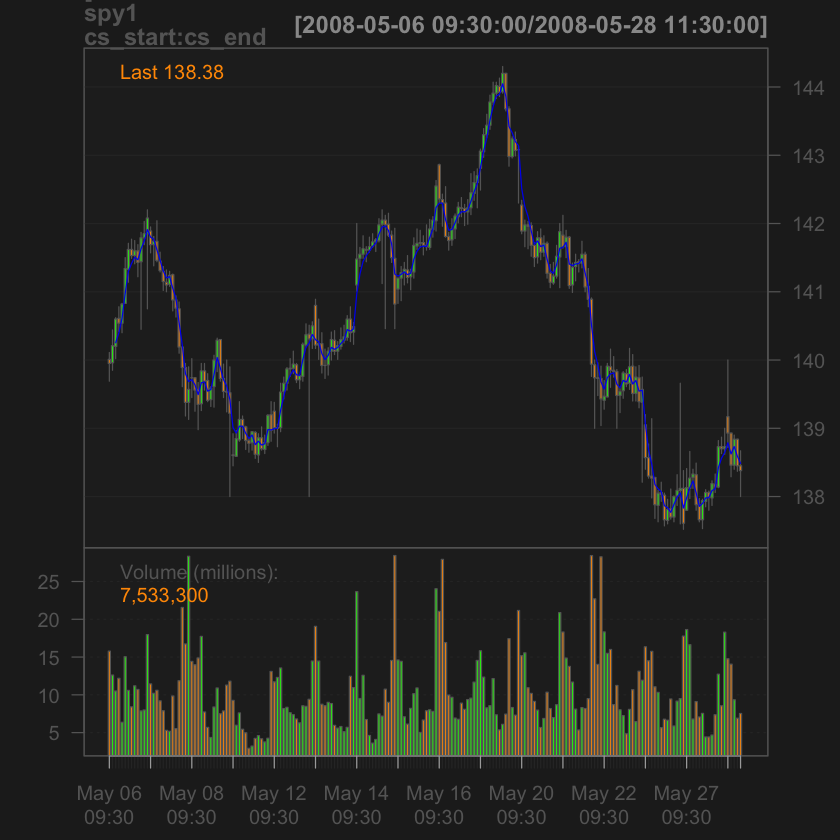

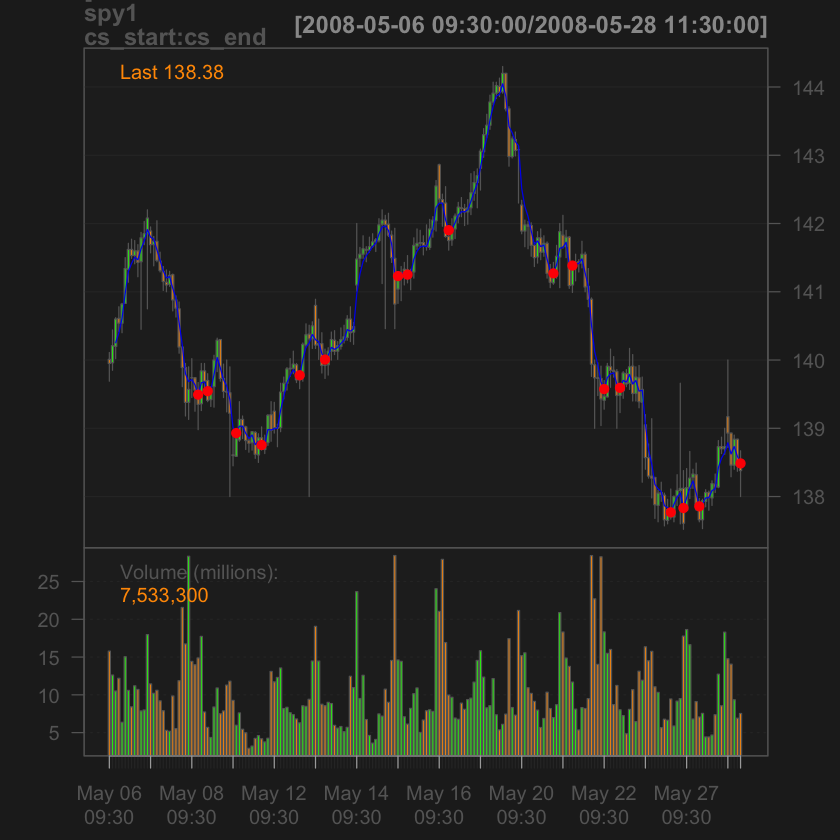

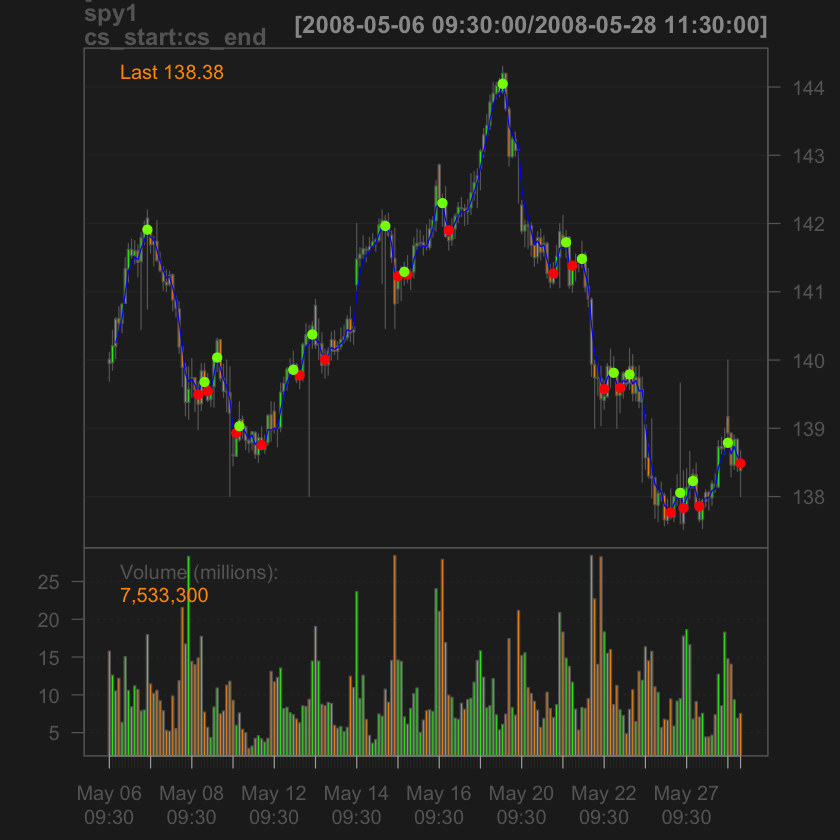

In [9]:
#plotting the candles with Local Min/Max's from starting candle

cs_start=1
cs_end=200

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

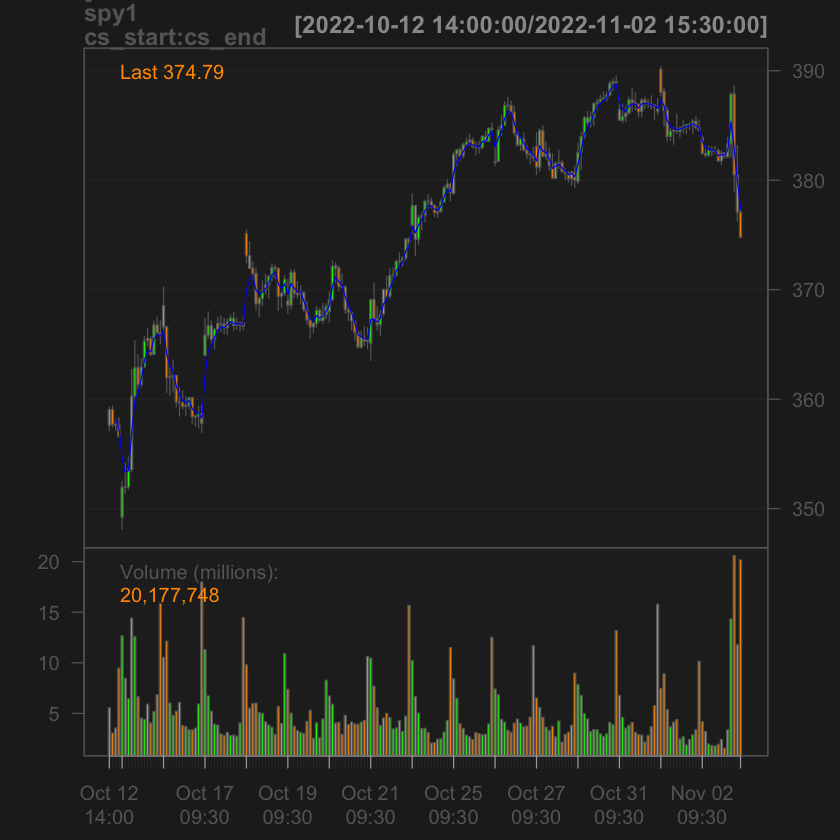

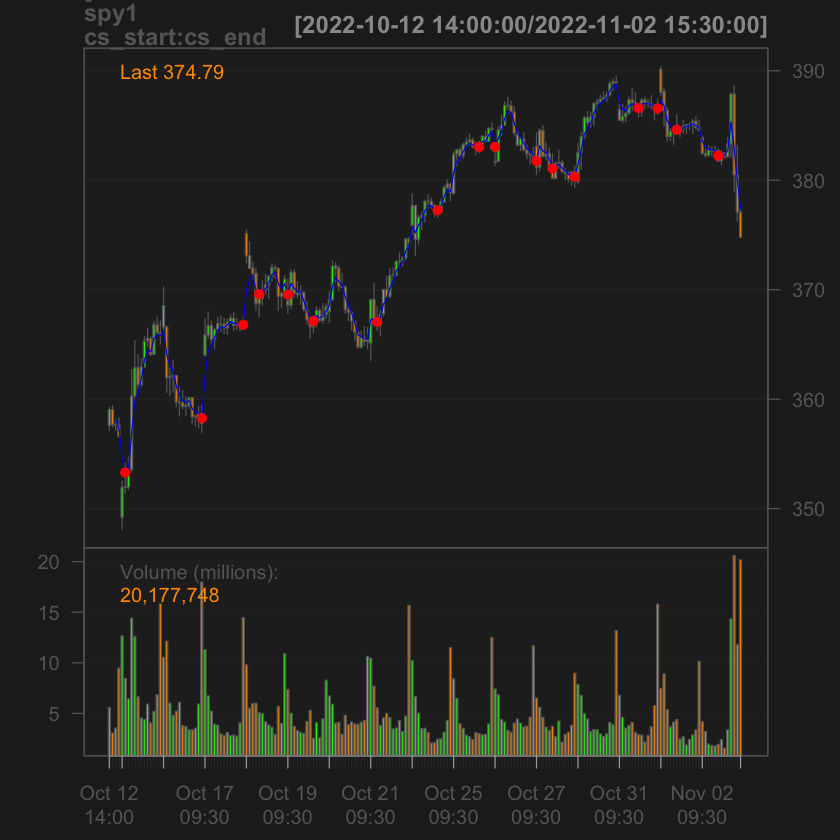

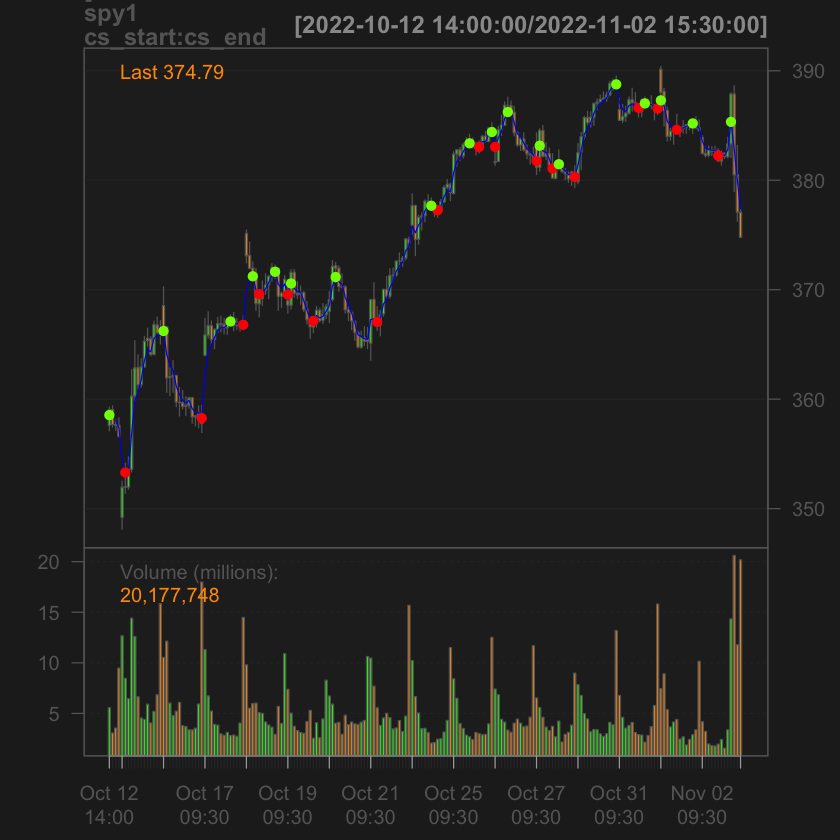

In [10]:
#plotting the candles with Local Min/Max's from ending candle

cs_start=47100
cs_end=47298

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

In [11]:
# First dot and last dot is a Local Max so throw out the last Local Max to have vectors of same length
local_maxs <- local_maxs[1:length(local_maxs)-1]
length(local_maxs)
length(local_mins)

[1] 4163

[1] 4163

In [12]:
# Do another loop for slope, distance, and amount difference between local_mins / local_maxs
local_min_amounts <- c()
local_min_slopes <- c()
local_min_dists <- c()
local_max_amounts <- c()
local_max_slopes <- c()
local_max_dists <- c()

for (i in 2:length(local_mins)) {
  if(is.numeric(local_mins[i]) & is.numeric(local_maxs[i])){
      min_dist <- local_mins[i] - local_mins[i-1]
      max_dist <- local_maxs[i] - local_maxs[i-1]
  
      local_min_amounts <- append(local_min_amounts, 
                              (spy_reversed$EMA3[local_mins[i]] - spy_reversed$EMA3[local_mins[i-1]]) / spy_reversed$EMA3[local_mins[i-1]] )
    
      local_min_slopes <- append(local_min_slopes, 
                             ((spy_reversed$EMA3[local_mins[i]] - spy_reversed$EMA3[local_mins[i-1]]) / spy_reversed$EMA3[local_mins[i-1]]) / min_dist)
    
      local_min_dists <- append(local_min_dists, min_dist)
    
      local_max_amounts <- append(local_max_amounts, 
                              (spy_reversed$EMA3[local_maxs[i]] - spy_reversed$EMA3[local_maxs[i-1]]) / spy_reversed$EMA3[local_maxs[i-1]])
    
      local_max_slopes <- append(local_max_slopes, 
                             ((spy_reversed$EMA3[local_maxs[i]] - spy_reversed$EMA3[local_maxs[i-1]]) / spy_reversed$EMA3[local_maxs[i-1]]) / max_dist)
    
      local_max_dists <- append(local_max_dists, max_dist)
    }
}

# Remove starting min or max to have equal length vectors
local_mins <- local_mins[2:length(local_mins)]
local_maxs <- local_maxs[2:length(local_maxs)]

length(local_min_amounts)
length(local_min_slopes)
length(local_min_dists)
length(local_max_amounts)
length(local_max_slopes)
length(local_max_dists)
length(local_mins)
length(local_maxs)


[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

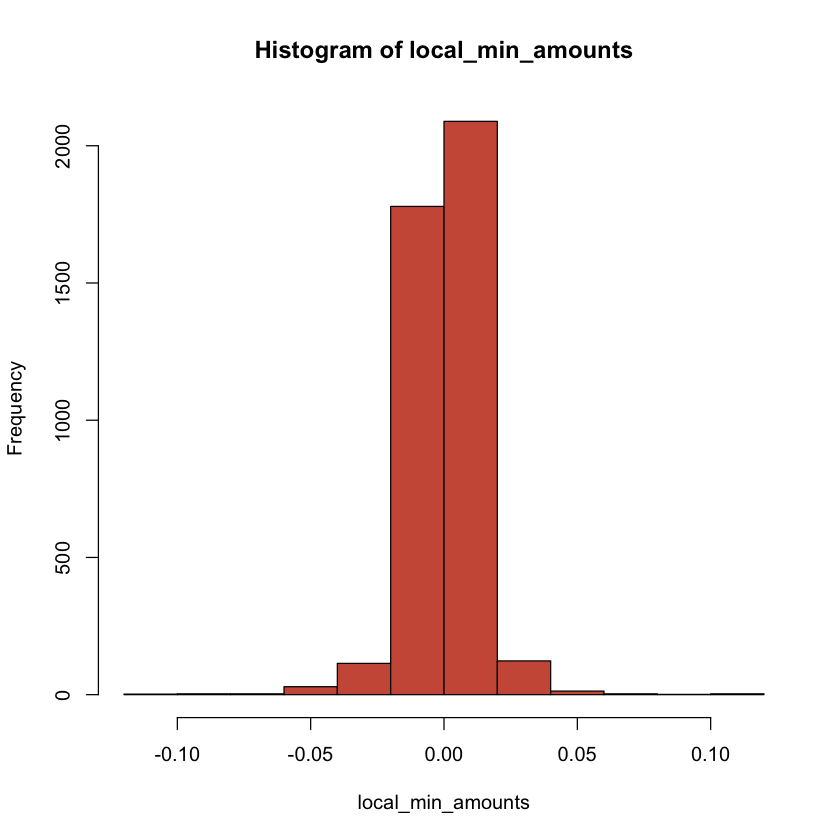

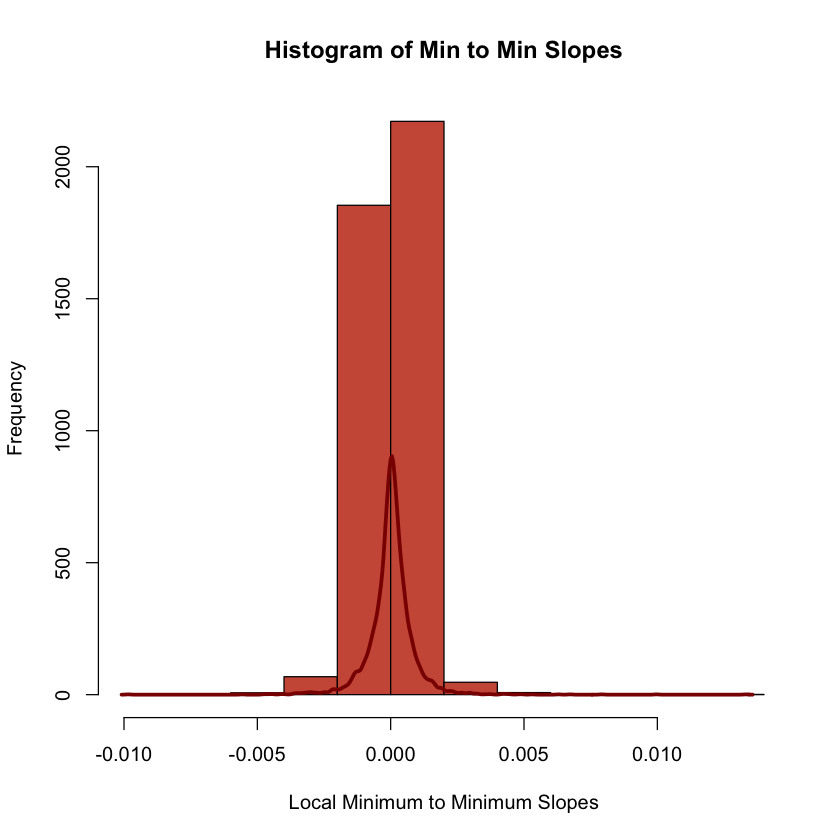

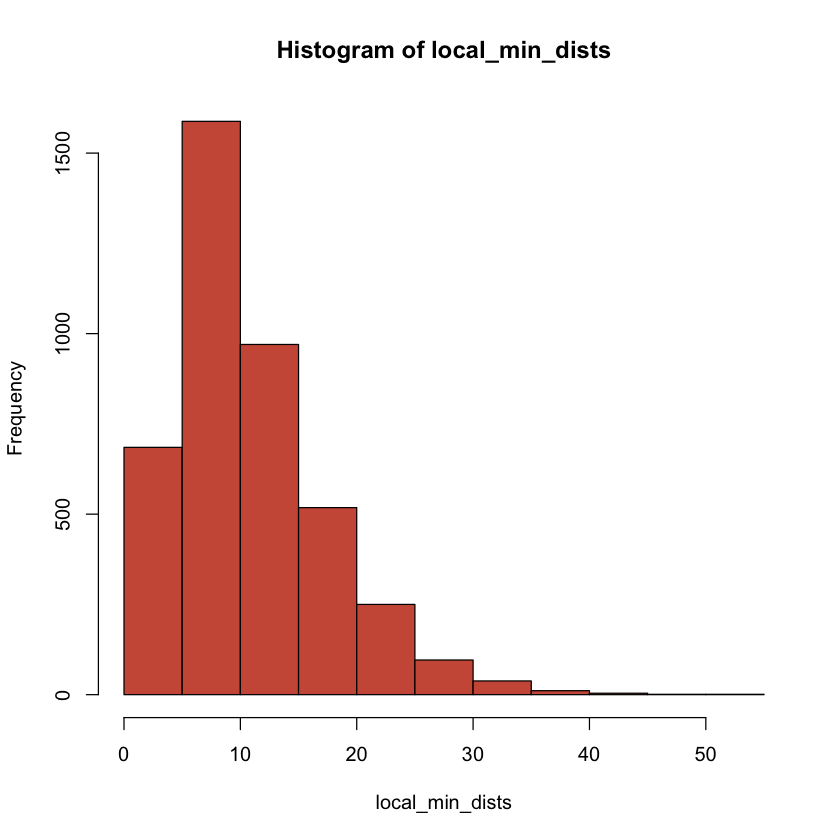

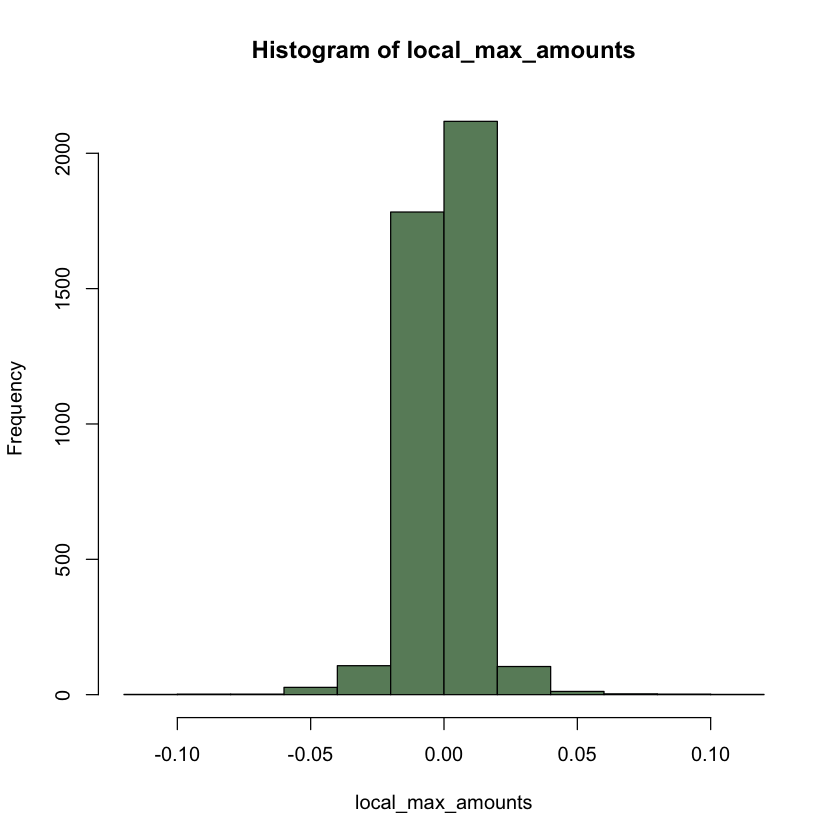

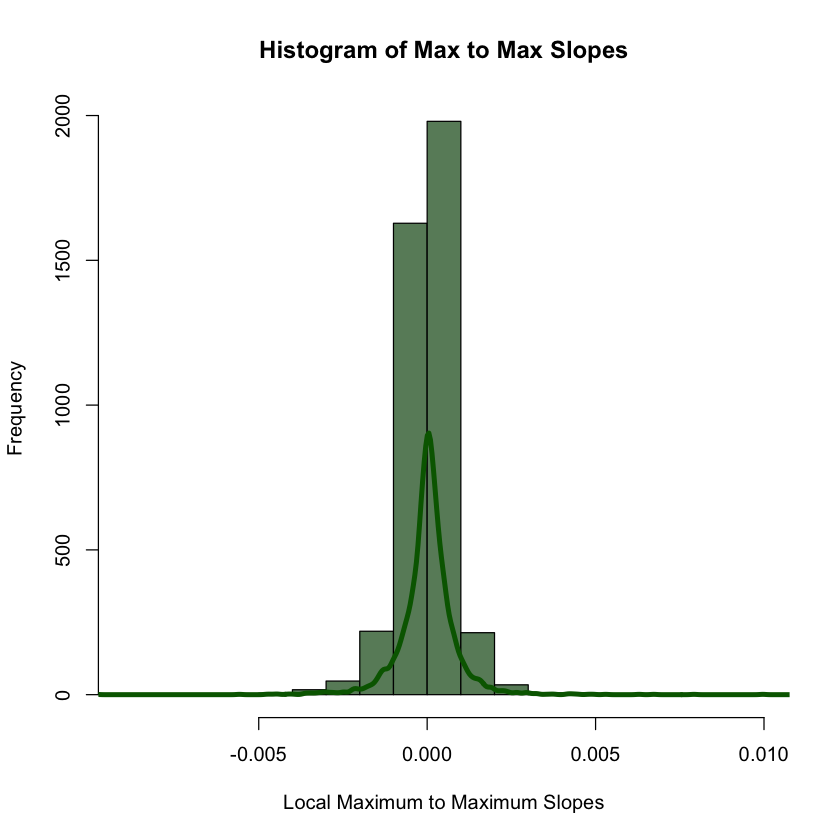

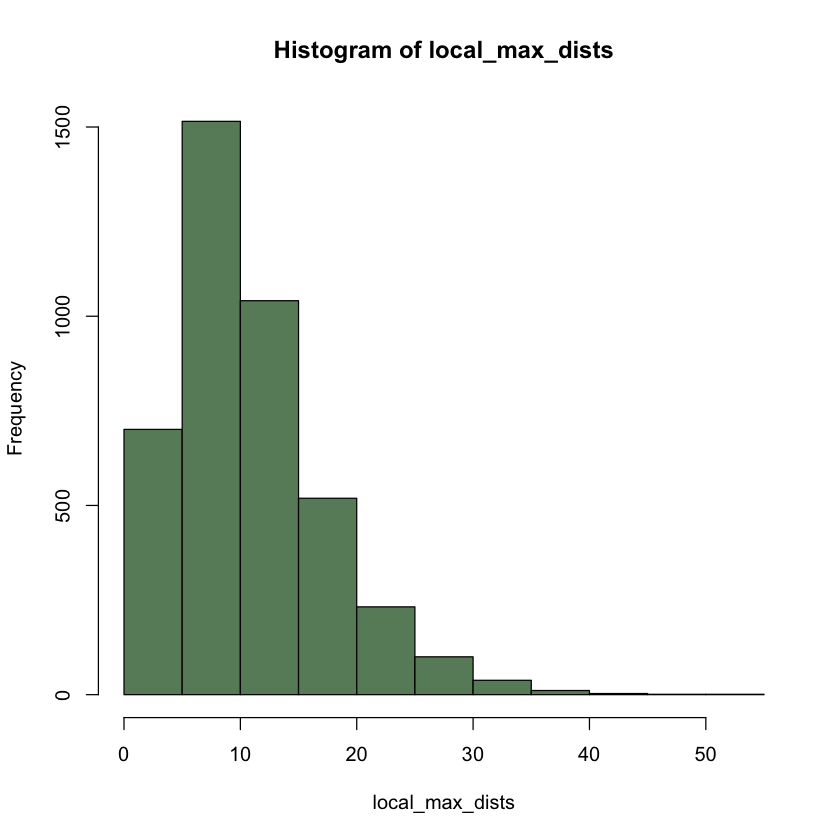

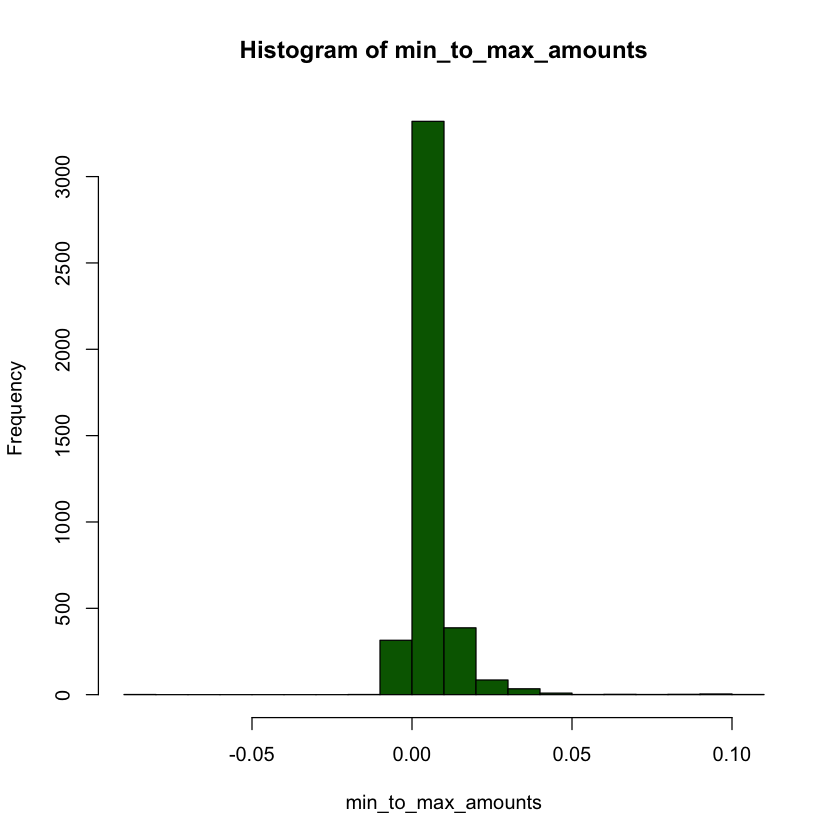

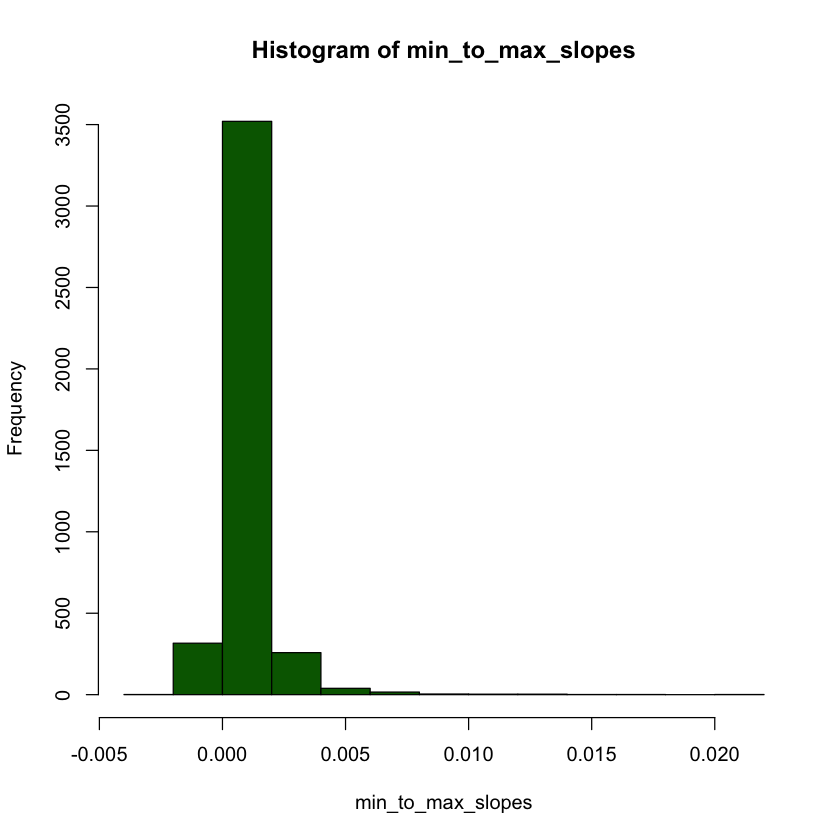

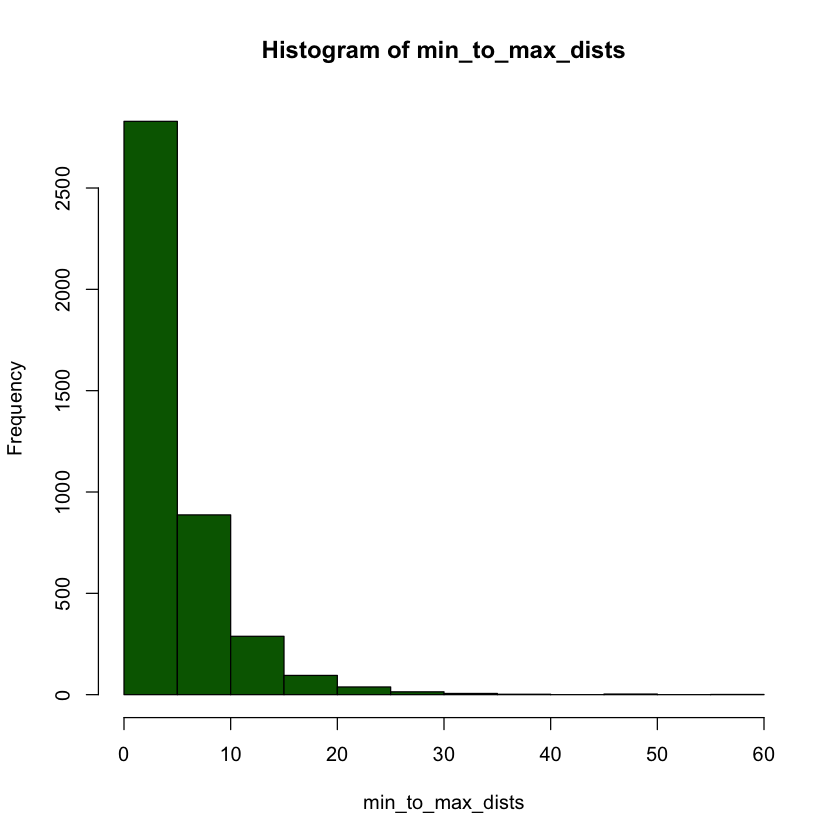

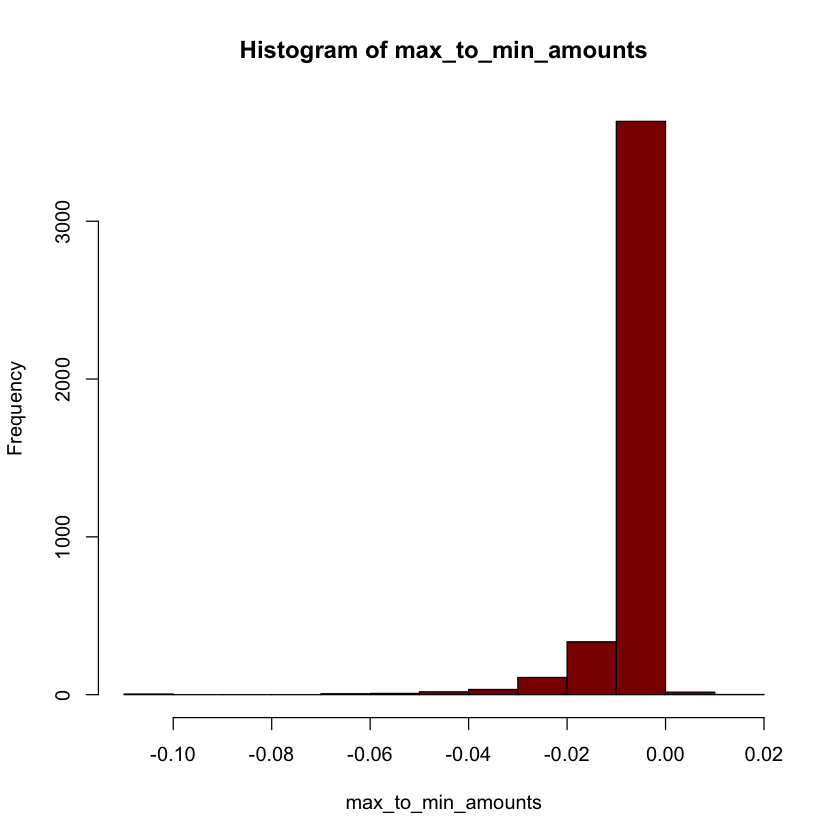

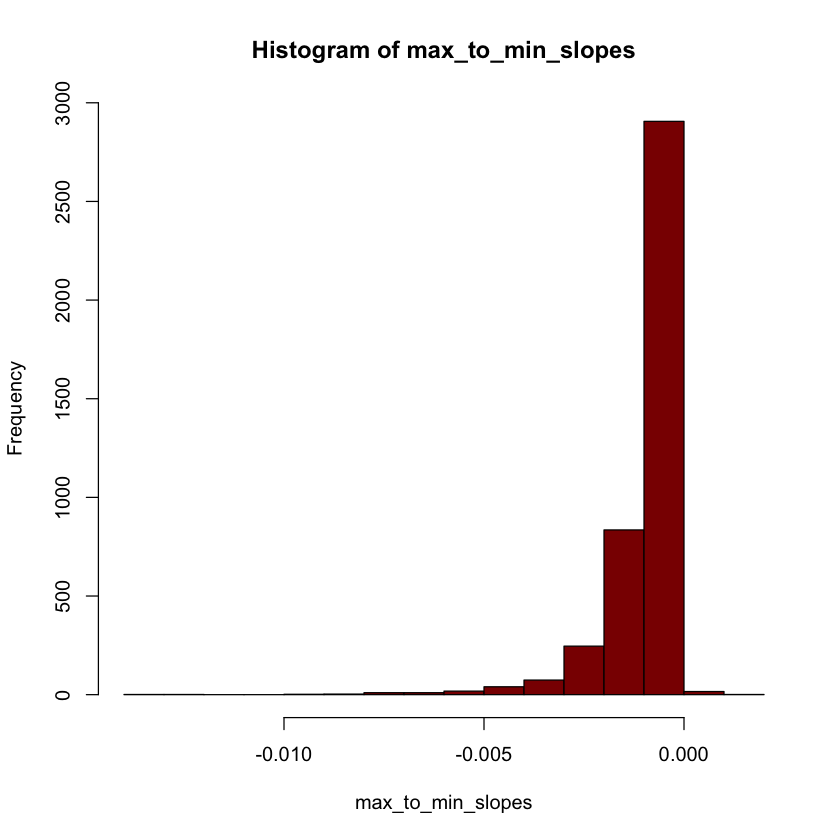

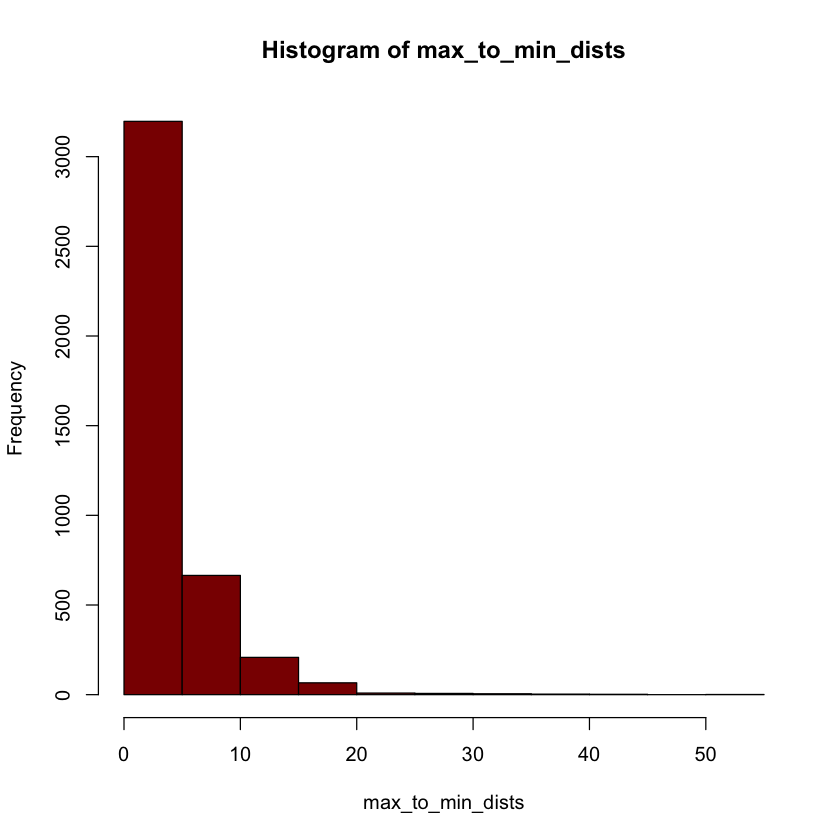

In [138]:
hist(local_min_amounts, col='coral3')
hist(local_min_slopes, col='coral3', main='Histogram of Min to Min Slopes',
    xlab='Local Minimum to Minimum Slopes')
lines(density(local_min_slopes),col='darkred',lwd=3)
hist(local_min_dists, col='coral3')
hist(local_max_amounts, col='darkseagreen4')
hist(local_max_slopes, col='darkseagreen4', main='Histogram of Max to Max Slopes',
    xlab='Local Maximum to Maximum Slopes')
lines(density(local_min_slopes),col='darkgreen',lwd=4)
hist(local_max_dists, col='darkseagreen4')
hist(min_to_max_amounts, col='darkgreen')
hist(min_to_max_slopes, col='darkgreen')
hist(min_to_max_dists, , col='darkgreen')
hist(max_to_min_amounts, col='darkred')
hist(max_to_min_slopes, col='darkred')
hist(max_to_min_dists, col='darkred')

In [14]:
# Remove first value and use this lag of the variable for predicting
# Made a lag for each variable to predict using linear regression model but performance was terrible
# Kept all lags in case they could have use in a logistic regression model

local_max_amounts_next1 <- c(local_max_amounts[2:length(local_max_amounts)],
                             local_max_amounts[length(local_max_amounts)])

local_max_slopes_next1 <- c(local_max_slopes[2:length(local_max_slopes)],
                             local_max_slopes[length(local_max_slopes)])

local_max_dists_next1 <- c(local_max_dists[2:length(local_max_dists)],
                            local_max_dists[length(local_max_dists)])

local_min_amounts_next1 <- c(local_min_amounts[2:length(local_min_amounts)],
                             local_min_amounts[length(local_min_amounts)])

local_min_slopes_next1 <- c(local_min_slopes[2:length(local_min_slopes)],
                            local_min_slopes[length(local_min_slopes)])

local_min_dists_next1 <- c(local_min_dists[2:length(local_min_dists)],
                           local_min_dists[length(local_min_dists)])

# Remove first two values because there was min_to_max and max_to_min before min_to_min and max_to_max
# This way they all start on the same dots
min_to_max_amounts_next1 <- c(min_to_max_amounts[3:length(min_to_max_amounts)],0)
min_to_max_slopes_next1 <- c(min_to_max_slopes[3:length(min_to_max_slopes)],0)
min_to_max_dists_next1 <- c(min_to_max_dists[3:length(min_to_max_dists)],0)

max_to_min_amounts_next1 <- c(max_to_min_amounts[3:length(max_to_min_amounts)],0)
max_to_min_slopes_next1 <- c(max_to_min_slopes[3:length(max_to_min_slopes)],0)
max_to_min_dists_next1 <- c(max_to_min_dists[3:length(max_to_min_dists)],0)


length(min_to_max_amounts_next1)
length(max_to_min_amounts_next1)
length(min_to_max_slopes_next1)
length(max_to_min_slopes_next1)
length(min_to_max_dists_next1)
length(max_to_min_dists_next1)
length(local_max_amounts_next1)
length(local_max_slopes_next1)
length(local_max_dists_next1)
length(local_min_amounts_next1)
length(local_min_slopes_next1)
length(local_min_dists_next1)

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

[1] 4162

In [15]:
# Making a dataframe
columns <- c('min_to_max_amounts_next1', 'max_to_min_amounts_next1',
              'min_to_max_slopes_next1', 'max_to_min_slopes_next1',
              'min_to_max_dists_next1', 'max_to_min_dists_next1',
              'local_max_amounts_next1', 'local_min_amounts_next1',
              'local_max_slopes_next1', 'local_min_slopes_next1',
              'local_max_dists_next1', 'local_min_dists_next1',
              'min_to_max_amounts', 'max_to_min_amounts',
              'min_to_max_slopes', 'max_to_min_slopes',
              'min_to_max_dists', 'max_to_min_dists',
              'local_max_amounts', 'local_min_amounts',
              'local_max_slopes', 'local_min_slopes',
              'local_max_dists', 'local_min_dists',
              'local_maxs', 'local_mins')
min_max_df <- data.frame(matrix(nrow = 1, ncol = length(columns)))
colnames(min_max_df) <- columns

# Fill the dataframe with info about Local Min/Max's slopes, etc, as it were to come in 
for (i in 1:length(local_mins)) {
  if(i>1){
      min_max_df <- rbind(min_max_df, c(min_to_max_amounts_next1[i], max_to_min_amounts_next1[i-1],
                          min_to_max_slopes_next1[i], max_to_min_slopes_next1[i-1],
                          min_to_max_dists_next1[i], max_to_min_dists_next1[i-1],
                          local_max_amounts_next1[i], local_min_amounts_next1[i-1],
                          local_max_slopes_next1[i], local_min_slopes_next1[i-1],
                          local_max_dists_next1[i], local_min_dists_next1[i-1],
                          min_to_max_amounts[i], max_to_min_amounts[i-1],
                          min_to_max_slopes[i], max_to_min_slopes[i-1],
                          min_to_max_dists[i], max_to_min_dists[i-1],
                          local_max_amounts[i], local_min_amounts[i-1],
                          local_max_slopes[i], local_min_slopes[i-1],
                          local_max_dists[i], local_min_dists[i-1],
                          local_maxs[i], local_mins[i-1]))
      min_max_df <- rbind(min_max_df, c(min_to_max_amounts_next1[i], max_to_min_amounts_next1[i],
                          min_to_max_slopes_next1[i], max_to_min_slopes_next1[i],
                          min_to_max_dists_next1[i], max_to_min_dists_next1[i],
                          local_max_amounts_next1[i], local_min_amounts_next1[i],
                          local_max_slopes_next1[i], local_min_slopes_next1[i],
                          local_max_dists_next1[i], local_min_dists_next1[i],
                          min_to_max_amounts[i], max_to_min_amounts[i],
                          min_to_max_slopes[i], max_to_min_slopes[i],
                          min_to_max_dists[i], max_to_min_dists[i],
                          local_max_amounts[i], local_min_amounts[i],
                          local_max_slopes[i], local_min_slopes[i],
                          local_max_dists[i], local_min_dists[i],
                          local_maxs[i], local_mins[i]))
  }
}
# Remove first row since it is filled with NAs
min_max_df <- min_max_df[2:nrow(min_max_df),]
head(min_max_df)

min_to_max_amounts_next1 max_to_min_amounts_next1 min_to_max_slopes_next1
2 0.0078113403             -6.814962e-03            0.0008679267           
3 0.0078113403             -1.976552e-03            0.0008679267           
4 0.0026492233             -1.976552e-03            0.0008830744           
5 0.0026492233             -4.721594e-05            0.0008830744           
6 0.0008260238             -4.721594e-05            0.0008260238           
7 0.0008260238             -2.067042e-03            0.0008260238           
  max_to_min_slopes_next1 min_to_max_dists_next1 max_to_min_dists_next1
2 -1.362992e-03           9                      5                     
3 -3.294253e-04           9                      6                     
4 -3.294253e-04           3                      6                     
5 -4.721594e-05           3                      1                     
6 -4.721594e-05           1                      1                     
7 -6.890140e-04           1                      3                     
  local_max_amounts_next1 local_min_amounts_next1 local_max_slopes_next1
2 -0.007188825            -0.004400043            -0.0010269750         
3 -0.007188825            -0.001258906            -0.0010269750         
4  0.005944756            -0.001258906             0.0003496915         
5  0.005944756             0.007361886             0.0003496915         
6  0.003700934             0.007361886             0.0006168223         
7  0.003700934             0.001648343             0.0006168223         
  local_min_slopes_next1 ⋯ min_to_max_dists max_to_min_dists local_max_amounts
2 -0.0004888936          ⋯ 2                15                0.002566612     
3 -0.0001573633          ⋯ 2                 0                0.002566612     
4 -0.0001573633          ⋯ 0                 0               -0.007188825     
5  0.0006134905          ⋯ 0                 5               -0.007188825     
6  0.0006134905          ⋯ 9                 5                0.005944756     
7  0.0002060429          ⋯ 9                 6                0.005944756     
  local_min_amounts local_max_slopes local_min_slopes local_max_dists
2  0.0003656095      0.0006416530     0.0001218698     4             
3 -0.0044000427      0.0006416530    -0.0004888936     4             
4 -0.0044000427     -0.0010269750    -0.0004888936     7             
5 -0.0012589065     -0.0010269750    -0.0001573633     7             
6 -0.0012589065      0.0003496915    -0.0001573633    17             
7  0.0073618863      0.0003496915     0.0006134905    17             
  local_min_dists local_maxs local_mins
2  3              35         32        
3  9              35         41        
4  9              42         41        
5  8              42         49        
6  8              59         49        
7 12              59         61

In [16]:
# Create a binary target variable for if the next max_to_max slope is +/- and same for min_to_min
binary_outcome_min_max_df <- min_max_df[,-c(25,26)] %>% 
                                mutate(binary_max_slopes_next1 = ifelse(local_max_slopes_next1>0,1,0)) %>% 
                                mutate(binary_min_slopes_next1 = ifelse(local_min_slopes_next1>0,1,0)) 

# Classify target variables as factors
binary_outcome_min_max_df$binary_max_slopes_next1 <- as.factor(binary_outcome_min_max_df$binary_max_slopes_next1)
binary_outcome_min_max_df$binary_min_slopes_next1 <- as.factor(binary_outcome_min_max_df$binary_min_slopes_next1)

head(binary_outcome_min_max_df)

min_to_max_amounts_next1 max_to_min_amounts_next1 min_to_max_slopes_next1
2 0.0078113403             -6.814962e-03            0.0008679267           
3 0.0078113403             -1.976552e-03            0.0008679267           
4 0.0026492233             -1.976552e-03            0.0008830744           
5 0.0026492233             -4.721594e-05            0.0008830744           
6 0.0008260238             -4.721594e-05            0.0008260238           
7 0.0008260238             -2.067042e-03            0.0008260238           
  max_to_min_slopes_next1 min_to_max_dists_next1 max_to_min_dists_next1
2 -1.362992e-03           9                      5                     
3 -3.294253e-04           9                      6                     
4 -3.294253e-04           3                      6                     
5 -4.721594e-05           3                      1                     
6 -4.721594e-05           1                      1                     
7 -6.890140e-04           1                      3                     
  local_max_amounts_next1 local_min_amounts_next1 local_max_slopes_next1
2 -0.007188825            -0.004400043            -0.0010269750         
3 -0.007188825            -0.001258906            -0.0010269750         
4  0.005944756            -0.001258906             0.0003496915         
5  0.005944756             0.007361886             0.0003496915         
6  0.003700934             0.007361886             0.0006168223         
7  0.003700934             0.001648343             0.0006168223         
  local_min_slopes_next1 ⋯ min_to_max_dists max_to_min_dists local_max_amounts
2 -0.0004888936          ⋯ 2                15                0.002566612     
3 -0.0001573633          ⋯ 2                 0                0.002566612     
4 -0.0001573633          ⋯ 0                 0               -0.007188825     
5  0.0006134905          ⋯ 0                 5               -0.007188825     
6  0.0006134905          ⋯ 9                 5                0.005944756     
7  0.0002060429          ⋯ 9                 6                0.005944756     
  local_min_amounts local_max_slopes local_min_slopes local_max_dists
2  0.0003656095      0.0006416530     0.0001218698     4             
3 -0.0044000427      0.0006416530    -0.0004888936     4             
4 -0.0044000427     -0.0010269750    -0.0004888936     7             
5 -0.0012589065     -0.0010269750    -0.0001573633     7             
6 -0.0012589065      0.0003496915    -0.0001573633    17             
7  0.0073618863      0.0003496915     0.0006134905    17             
  local_min_dists binary_max_slopes_next1 binary_min_slopes_next1
2  3              0                       0                      
3  9              0                       0                      
4  9              1                       0                      
5  8              1                       1                      
6  8              1                       1                      
7 12              1                       1

In [17]:
# Correlation matrix of possible variables
cor(binary_outcome_min_max_df[,-c(1:12,25:26)])

min_to_max_amounts max_to_min_amounts min_to_max_slopes
min_to_max_amounts  1.00000000        -0.229514003        0.65561094      
max_to_min_amounts -0.22951400         1.000000000       -0.33471988      
min_to_max_slopes   0.65561094        -0.334719875        1.00000000      
max_to_min_slopes  -0.30125726         0.672206657       -0.41864395      
min_to_max_dists    0.53790851         0.022618121        0.07727071      
max_to_min_dists    0.05479084        -0.658212502        0.09414541      
local_max_amounts   0.54540443         0.296128481        0.25327711      
local_min_amounts   0.27520398         0.030558406        0.12060876      
local_max_slopes    0.50923343         0.271218354        0.32529467      
local_min_slopes    0.26771376         0.037535242        0.16931086      
local_max_dists     0.40116843        -0.178956489        0.09138142      
local_min_dists     0.17529678         0.001682741        0.03007573      
                   max_to_min_slopes min_to_max_dists max_to_min_dists
min_to_max_amounts -0.30125726        0.53790851       0.054790836    
max_to_min_amounts  0.67220666        0.02261812      -0.658212502    
min_to_max_slopes  -0.41864395        0.07727071       0.094145411    
max_to_min_slopes   1.00000000        0.01050288      -0.209252757    
min_to_max_dists    0.01050288        1.00000000      -0.019866808    
max_to_min_dists   -0.20925276       -0.01986681       1.000000000    
local_max_amounts   0.13528785        0.40079275      -0.236110802    
local_min_amounts  -0.01340939        0.20633641      -0.031255607    
local_max_slopes    0.16672336        0.34010041      -0.201764633    
local_min_slopes   -0.02833025        0.17318599      -0.029159091    
local_max_dists    -0.07396571        0.67025671       0.250447299    
local_min_dists    -0.00960717        0.31249079       0.002637218    
                   local_max_amounts local_min_amounts local_max_slopes
min_to_max_amounts  0.54540443        0.27520398        0.50923343     
max_to_min_amounts  0.29612848        0.03055841        0.27121835     
min_to_max_slopes   0.25327711        0.12060876        0.32529467     
max_to_min_slopes   0.13528785       -0.01340939        0.16672336     
min_to_max_dists    0.40079275        0.20633641        0.34010041     
max_to_min_dists   -0.23611080       -0.03125561       -0.20176463     
local_max_amounts   1.00000000        0.52994825        0.90200551     
local_min_amounts   0.52994825        1.00000000        0.48752404     
local_max_slopes    0.90200551        0.48752404        1.00000000     
local_min_slopes    0.48672732        0.90996701        0.51331870     
local_max_dists     0.06751023        0.02183840        0.04903561     
local_min_dists     0.02441497        0.04479792        0.01236050     
                   local_min_slopes local_max_dists local_min_dists
min_to_max_amounts  0.267713759      0.401168430     0.175296780   
max_to_min_amounts  0.037535242     -0.178956489     0.001682741   
min_to_max_slopes   0.169310862      0.091381420     0.030075734   
max_to_min_slopes  -0.028330250     -0.073965709    -0.009607170   
min_to_max_dists    0.173185989      0.670256709     0.312490788   
max_to_min_dists   -0.029159091      0.250447299     0.002637218   
local_max_amounts   0.486727323      0.067510232     0.024414972   
local_min_amounts   0.909967013      0.021838403     0.044797921   
local_max_slopes    0.513318696      0.049035611     0.012360504   
local_min_slopes    1.000000000      0.007638293     0.015888369   
local_max_dists     0.007638293      1.000000000     0.496793411   
local_min_dists     0.015888369      0.496793411     1.000000000

In [18]:
# Correlation matrix of possible variables without amounts (just slopes and distances)
cor(binary_outcome_min_max_df[,-c(1:14,19:20,25:26)])

min_to_max_slopes max_to_min_slopes min_to_max_dists
min_to_max_slopes  1.00000000       -0.41864395        0.07727071     
max_to_min_slopes -0.41864395        1.00000000        0.01050288     
min_to_max_dists   0.07727071        0.01050288        1.00000000     
max_to_min_dists   0.09414541       -0.20925276       -0.01986681     
local_max_slopes   0.32529467        0.16672336        0.34010041     
local_min_slopes   0.16931086       -0.02833025        0.17318599     
local_max_dists    0.09138142       -0.07396571        0.67025671     
local_min_dists    0.03007573       -0.00960717        0.31249079     
                  max_to_min_dists local_max_slopes local_min_slopes
min_to_max_slopes  0.094145411      0.32529467       0.169310862    
max_to_min_slopes -0.209252757      0.16672336      -0.028330250    
min_to_max_dists  -0.019866808      0.34010041       0.173185989    
max_to_min_dists   1.000000000     -0.20176463      -0.029159091    
local_max_slopes  -0.201764633      1.00000000       0.513318696    
local_min_slopes  -0.029159091      0.51331870       1.000000000    
local_max_dists    0.250447299      0.04903561       0.007638293    
local_min_dists    0.002637218      0.01236050       0.015888369    
                  local_max_dists local_min_dists
min_to_max_slopes  0.091381420     0.030075734   
max_to_min_slopes -0.073965709    -0.009607170   
min_to_max_dists   0.670256709     0.312490788   
max_to_min_dists   0.250447299     0.002637218   
local_max_slopes   0.049035611     0.012360504   
local_min_slopes   0.007638293     0.015888369   
local_max_dists    1.000000000     0.496793411   
local_min_dists    0.496793411     1.000000000

In [19]:
# Correlation matrix of possible variables without slopes (just amounts and distances)
cor(binary_outcome_min_max_df[,-c(1:12,15:16,21:22,25:26)])

min_to_max_amounts max_to_min_amounts min_to_max_dists
min_to_max_amounts  1.00000000        -0.229514003        0.53790851     
max_to_min_amounts -0.22951400         1.000000000        0.02261812     
min_to_max_dists    0.53790851         0.022618121        1.00000000     
max_to_min_dists    0.05479084        -0.658212502       -0.01986681     
local_max_amounts   0.54540443         0.296128481        0.40079275     
local_min_amounts   0.27520398         0.030558406        0.20633641     
local_max_dists     0.40116843        -0.178956489        0.67025671     
local_min_dists     0.17529678         0.001682741        0.31249079     
                   max_to_min_dists local_max_amounts local_min_amounts
min_to_max_amounts  0.054790836      0.54540443        0.27520398      
max_to_min_amounts -0.658212502      0.29612848        0.03055841      
min_to_max_dists   -0.019866808      0.40079275        0.20633641      
max_to_min_dists    1.000000000     -0.23611080       -0.03125561      
local_max_amounts  -0.236110802      1.00000000        0.52994825      
local_min_amounts  -0.031255607      0.52994825        1.00000000      
local_max_dists     0.250447299      0.06751023        0.02183840      
local_min_dists     0.002637218      0.02441497        0.04479792      
                   local_max_dists local_min_dists
min_to_max_amounts  0.40116843     0.175296780    
max_to_min_amounts -0.17895649     0.001682741    
min_to_max_dists    0.67025671     0.312490788    
max_to_min_dists    0.25044730     0.002637218    
local_max_amounts   0.06751023     0.024414972    
local_min_amounts   0.02183840     0.044797921    
local_max_dists     1.00000000     0.496793411    
local_min_dists     0.49679341     1.000000000

In [20]:
# Correlation matrix of slopes
cor(binary_outcome_min_max_df[,c(15:16,21:22)])

min_to_max_slopes max_to_min_slopes local_max_slopes
min_to_max_slopes  1.0000000        -0.41864395       0.3252947       
max_to_min_slopes -0.4186439         1.00000000       0.1667234       
local_max_slopes   0.3252947         0.16672336       1.0000000       
local_min_slopes   0.1693109        -0.02833025       0.5133187       
                  local_min_slopes
min_to_max_slopes  0.16931086     
max_to_min_slopes -0.02833025     
local_max_slopes   0.51331870     
local_min_slopes   1.00000000

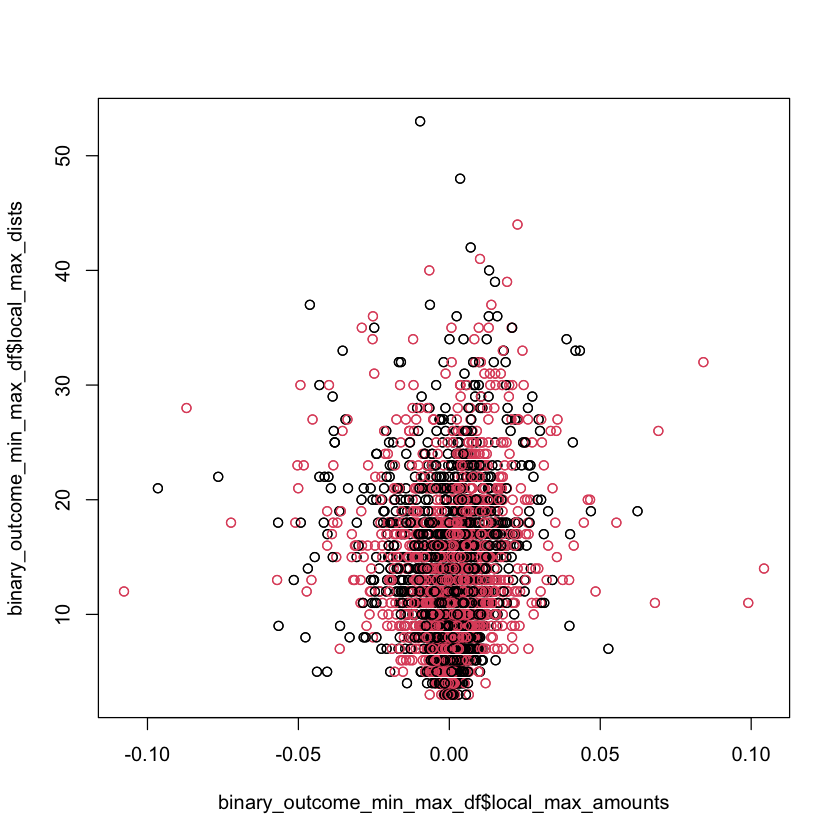

In [21]:
# Local Max Slope Vs Local Max Distance
plot(binary_outcome_min_max_df$local_max_amounts, binary_outcome_min_max_df$local_max_dists,
    col=binary_outcome_min_max_df$binary_max_slopes_next1)

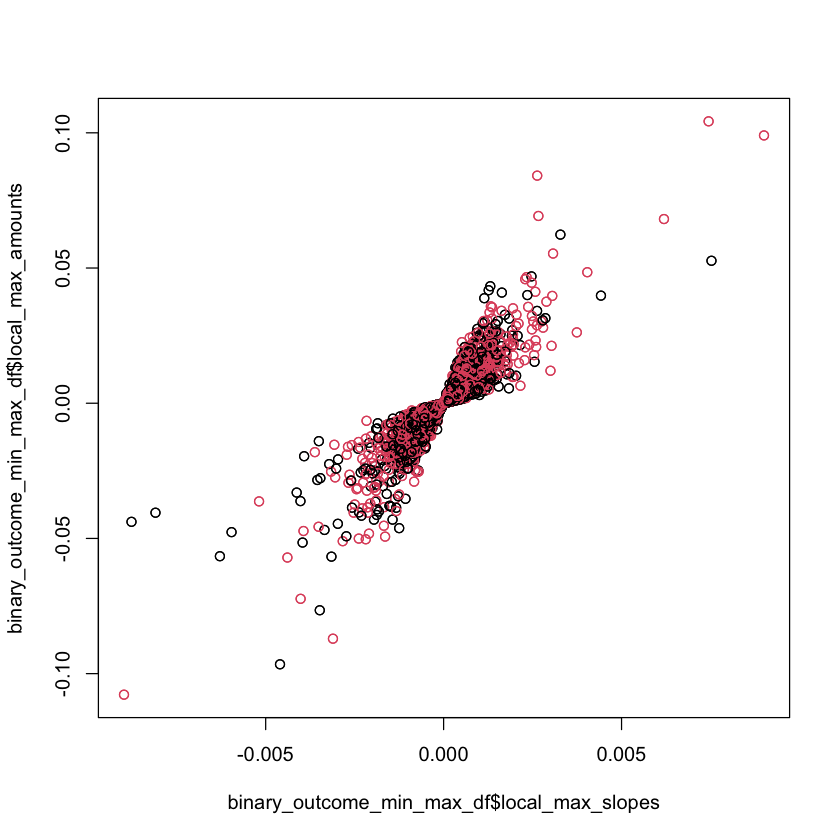

In [22]:
# Local Max Slope Vs Local Max Amounts
plot(binary_outcome_min_max_df$local_max_slopes, binary_outcome_min_max_df$local_max_amounts,
    col=binary_outcome_min_max_df$binary_max_slopes_next1)

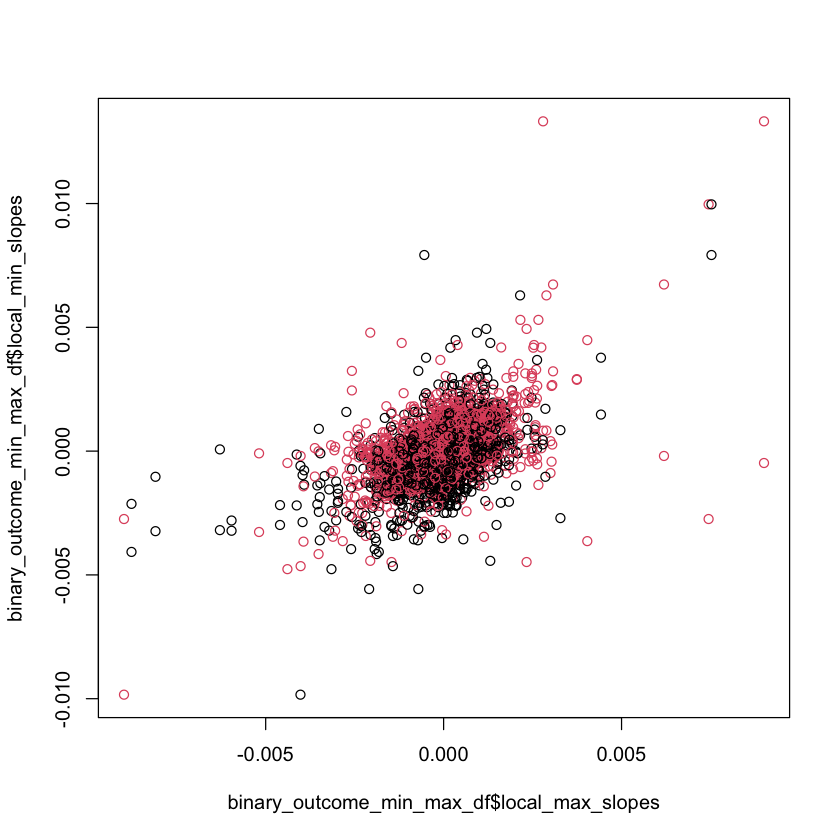

In [23]:
# Local Max Slope Vs Local Min Slopes
plot(binary_outcome_min_max_df$local_max_slopes, binary_outcome_min_max_df$local_min_slopes,
    col=binary_outcome_min_max_df$binary_max_slopes_next1)

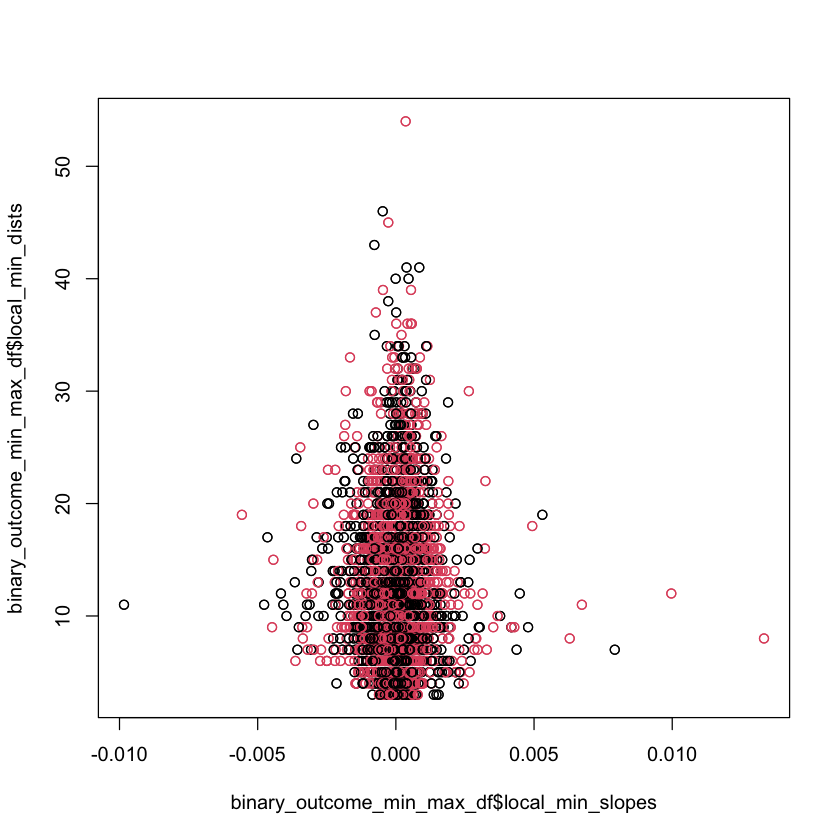

In [24]:
# Local Min Slope Vs Local Min Distances
plot(binary_outcome_min_max_df$local_min_slopes, binary_outcome_min_max_df$local_min_dists,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

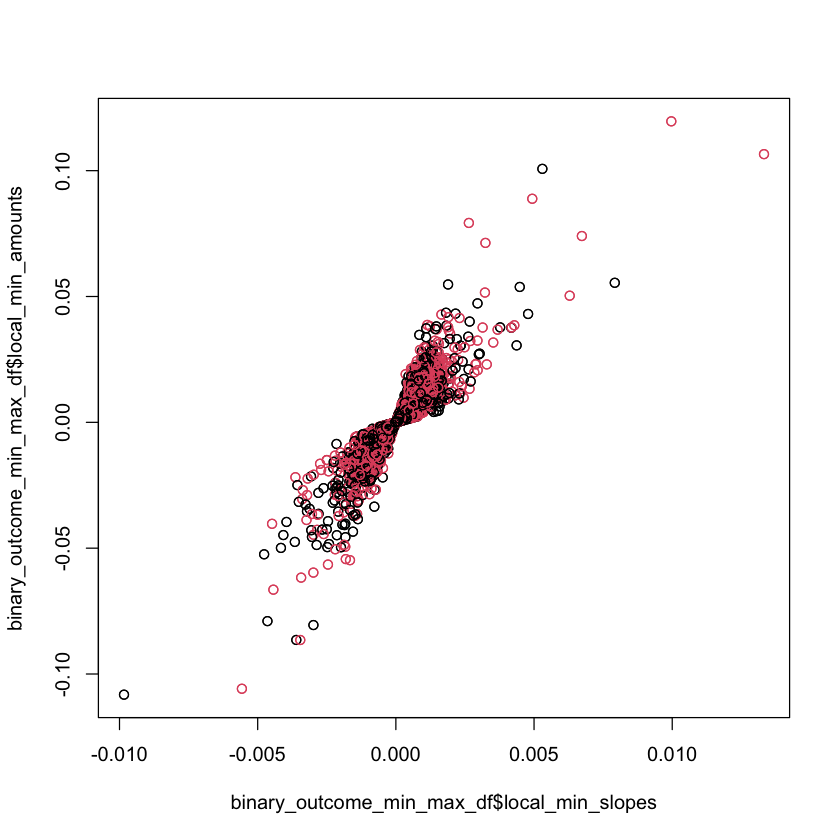

In [25]:
# Local Min Slope Vs Local Min Amounts
plot(binary_outcome_min_max_df$local_min_slopes, binary_outcome_min_max_df$local_min_amounts,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

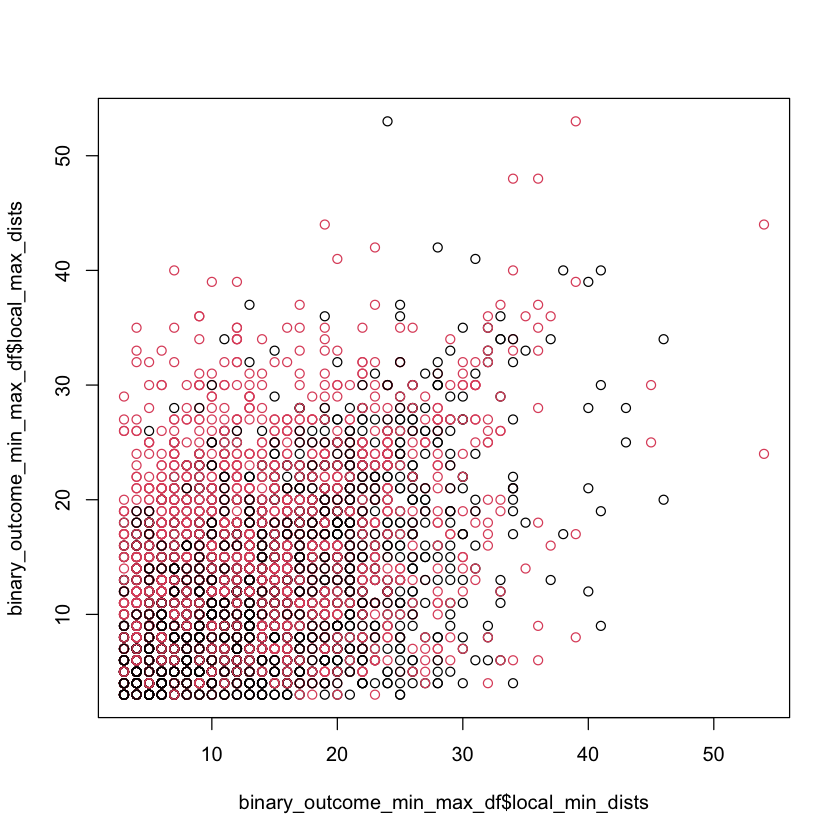

In [26]:
# Local Min Distance Vs Local Max Distance
plot(binary_outcome_min_max_df$local_min_dists, binary_outcome_min_max_df$local_max_dists,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

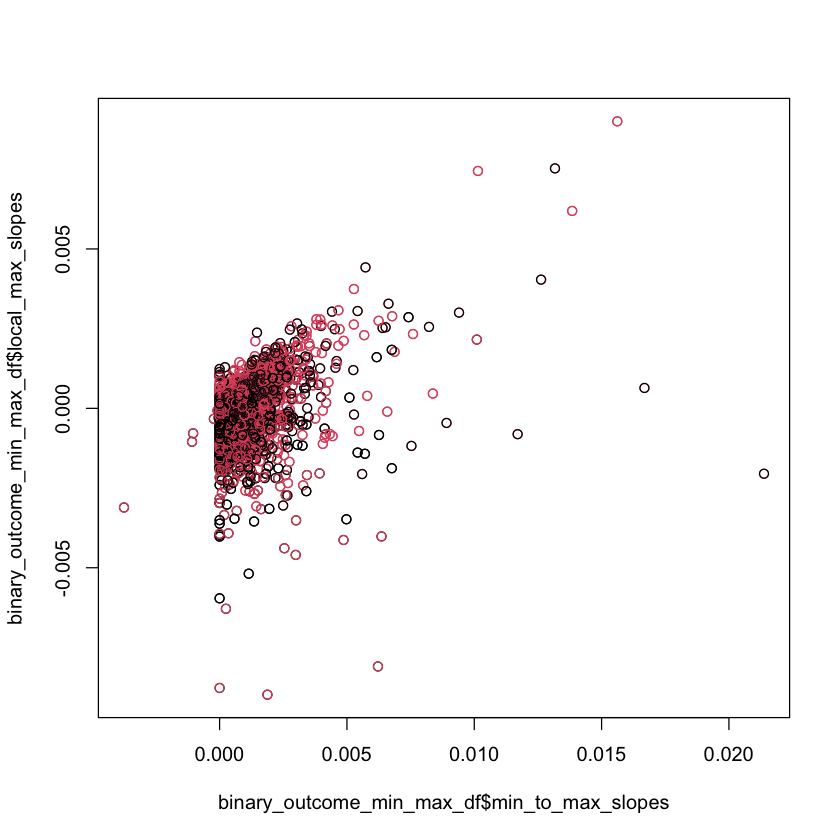

In [27]:
# Min to Max Slope Vs Local Max Slope
plot(binary_outcome_min_max_df$min_to_max_slopes, binary_outcome_min_max_df$local_max_slopes,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

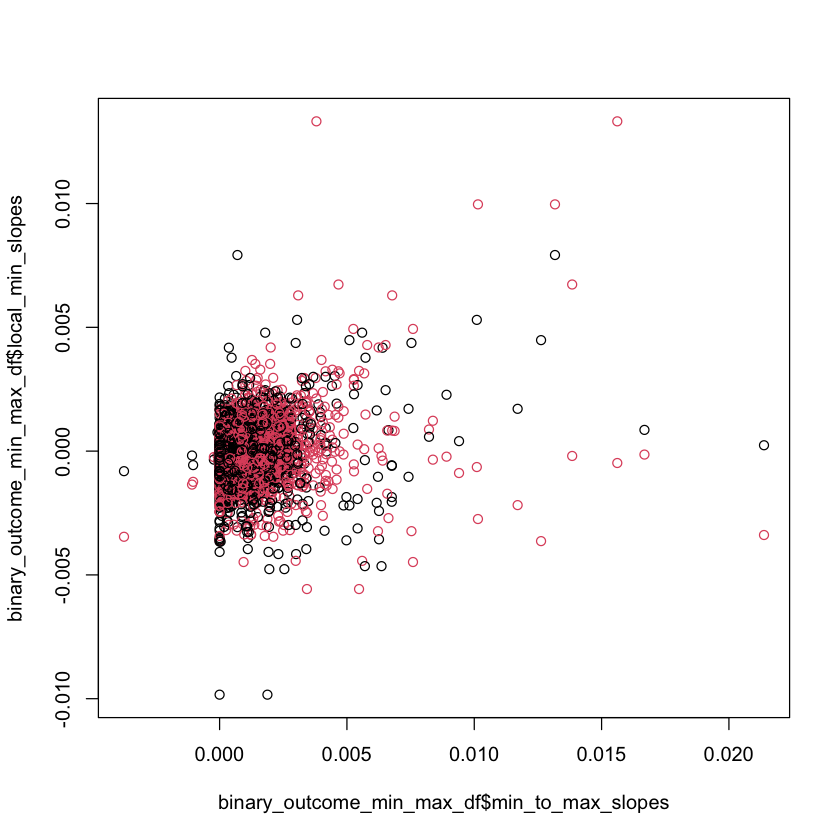

In [28]:
# Min to Max Slope Vs Local Min Slope
plot(binary_outcome_min_max_df$min_to_max_slopes, binary_outcome_min_max_df$local_min_slopes,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

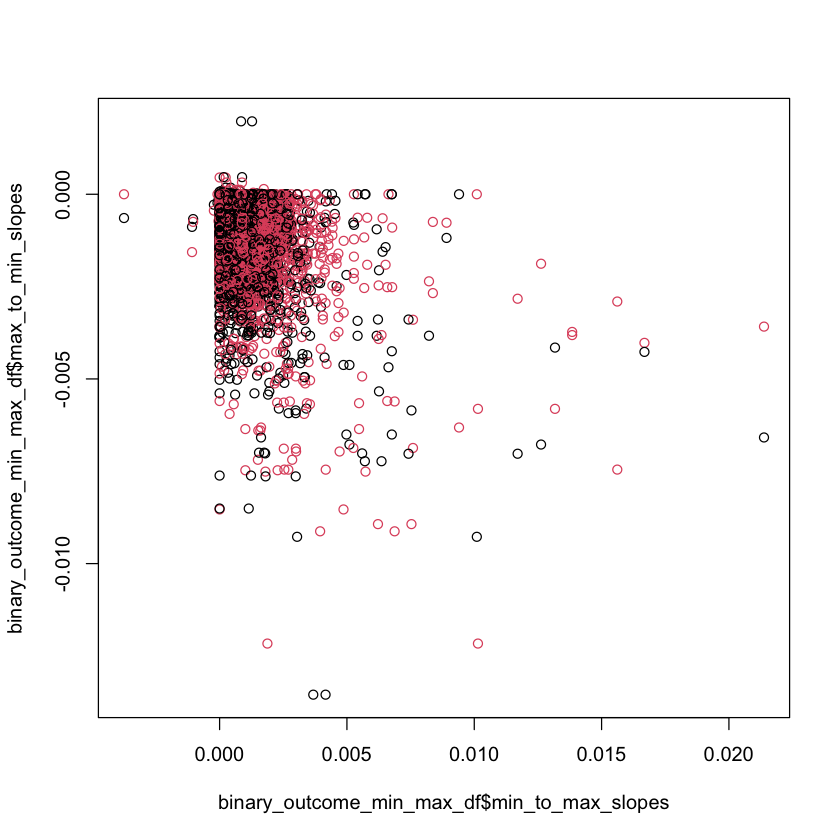

In [29]:
# Min to Max Slope Vs Max to Min Slope
plot(binary_outcome_min_max_df$min_to_max_slopes, binary_outcome_min_max_df$max_to_min_slopes,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

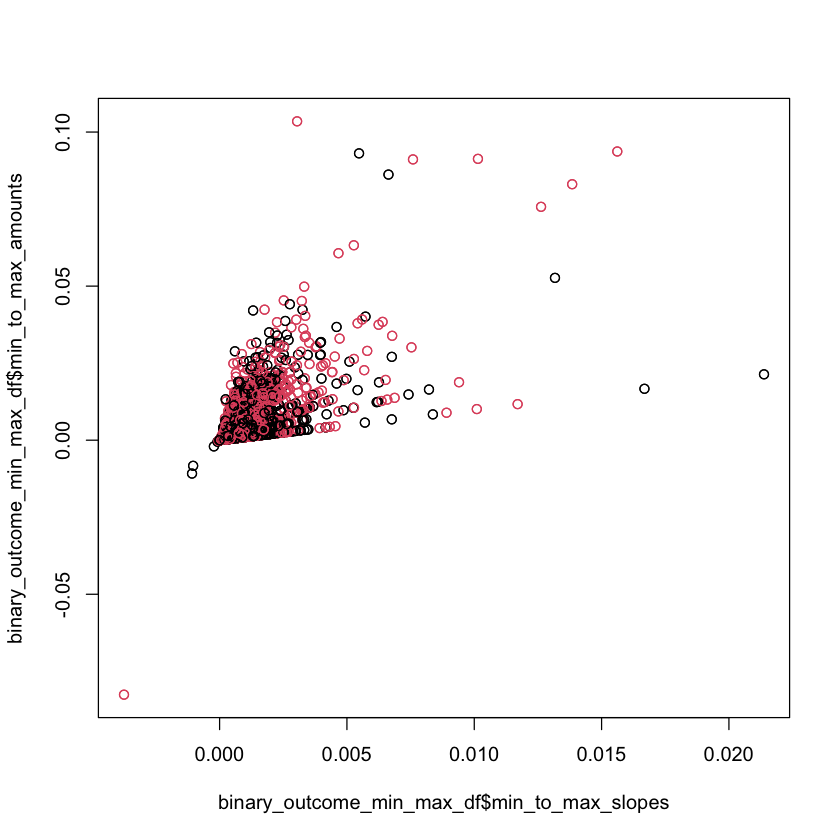

In [30]:
# Min to Max Slope Vs Min to Max Amount
plot(binary_outcome_min_max_df$min_to_max_slopes, binary_outcome_min_max_df$min_to_max_amounts,
    col=binary_outcome_min_max_df$binary_max_slopes_next1)

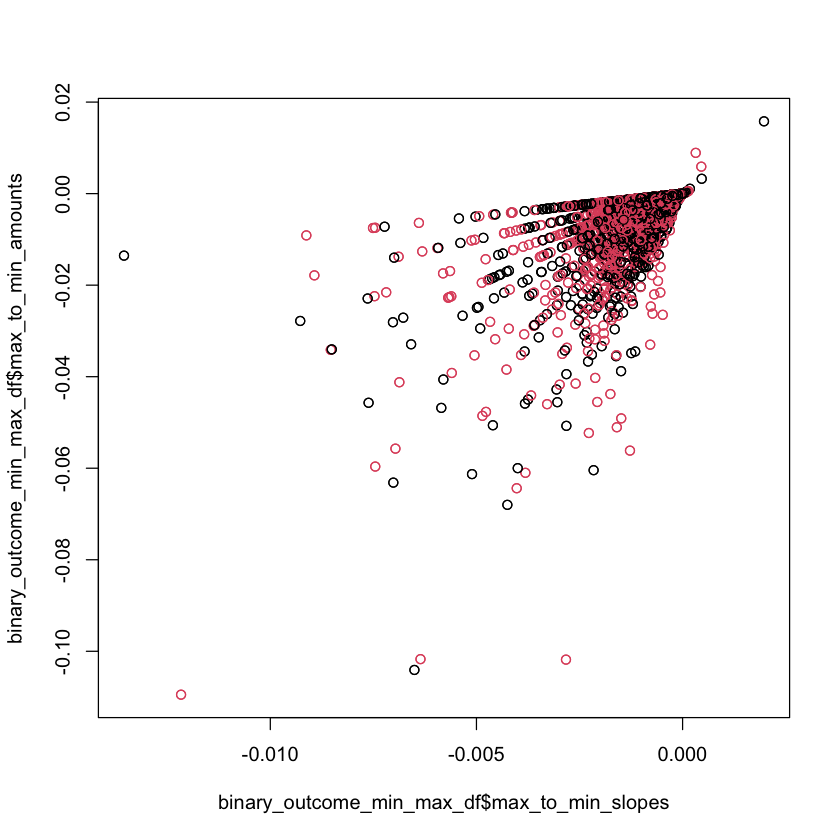

In [31]:
# Max to Min Slope Vs Max to Min Amount
plot(binary_outcome_min_max_df$max_to_min_slopes, binary_outcome_min_max_df$max_to_min_amounts,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

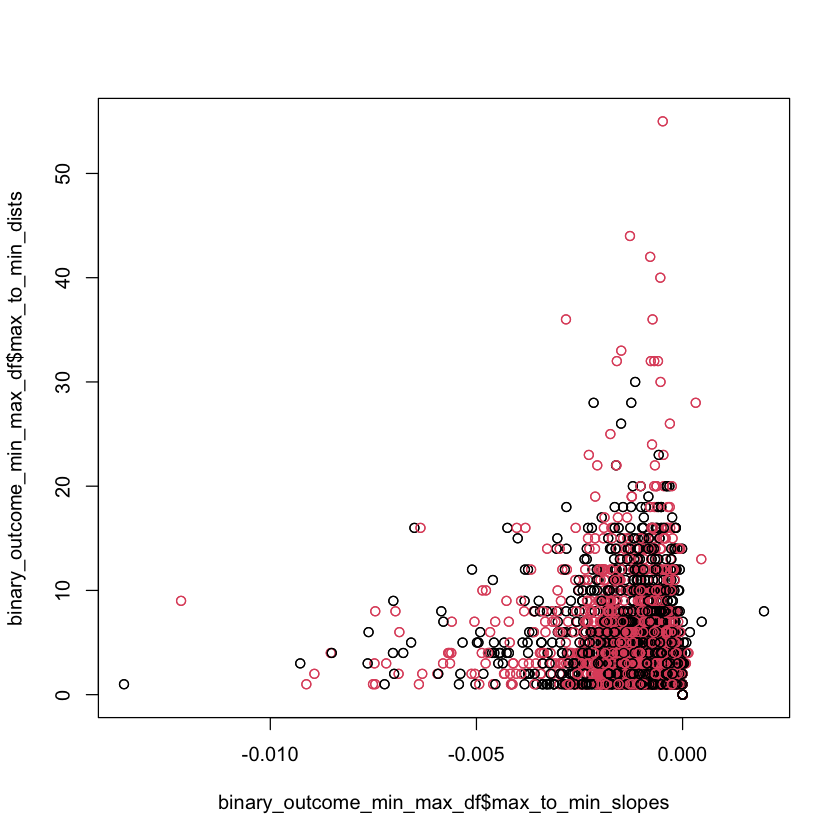

In [32]:
# Max to Min Slope Vs Max to Min Distance
plot(binary_outcome_min_max_df$max_to_min_slopes, binary_outcome_min_max_df$max_to_min_dists,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

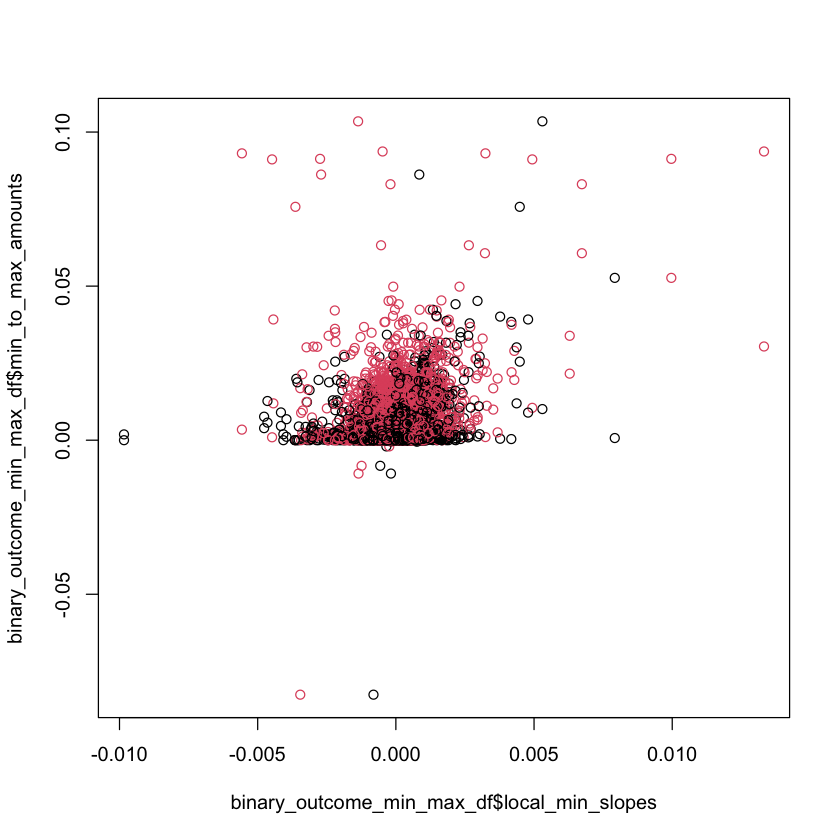

In [33]:
# Local Min Slope Vs Min to Max Amount
plot(binary_outcome_min_max_df$local_min_slopes, binary_outcome_min_max_df$min_to_max_amounts,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

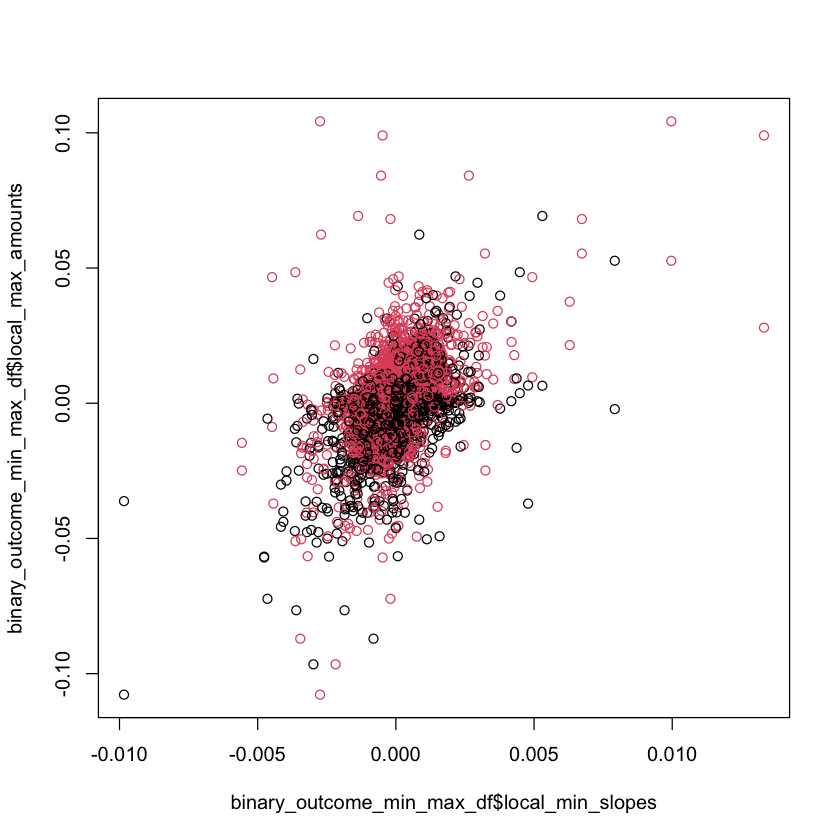

In [34]:
# Local Min Slope Vs Local Max Amount
plot(binary_outcome_min_max_df$local_min_slopes, binary_outcome_min_max_df$local_max_amounts,
    col=binary_outcome_min_max_df$binary_min_slopes_next1)

In [35]:
# Since the target variable is simply to predict if the next local minimum is higher than the last found one
# and likewise for local maximums, it should be possible to remove the 'amounts' variable because of the strong
# correlation to the slopes of its kind. Thus, removing redundancy of the variables.

Standard deviations (1, .., p=13):
 [1] 1.9486670 1.6262969 1.3446338 1.1475646 0.9643718 0.8524963 0.7928251
 [8] 0.6453974 0.4869546 0.4265489 0.3887390 0.3282585 0.2304297

Rotation (n x k) = (13 x 13):
                               PC1         PC2         PC3         PC4
local_min_slopes_next1  0.17347798  0.09933133  0.01376284 -0.38644926
min_to_max_amounts      0.40024424  0.23416889  0.02796605 -0.24675801
max_to_min_amounts      0.01847019 -0.53616546  0.23032555 -0.13756553
min_to_max_slopes       0.24840628  0.27480539 -0.24216242 -0.34416080
max_to_min_slopes      -0.04072128 -0.43473269  0.27449591  0.04842283
min_to_max_dists        0.31144382  0.10000869  0.43599014  0.04681972
max_to_min_dists       -0.04270958  0.39740458 -0.08705672  0.30456327
local_max_amounts       0.42998457 -0.21067572 -0.03789544 -0.13594850
local_min_amounts       0.34711130 -0.13154733 -0.25145069  0.47395001
local_max_slopes        0.42237129 -0.20497163 -0.07100712 -0.15143312
local_min_slo

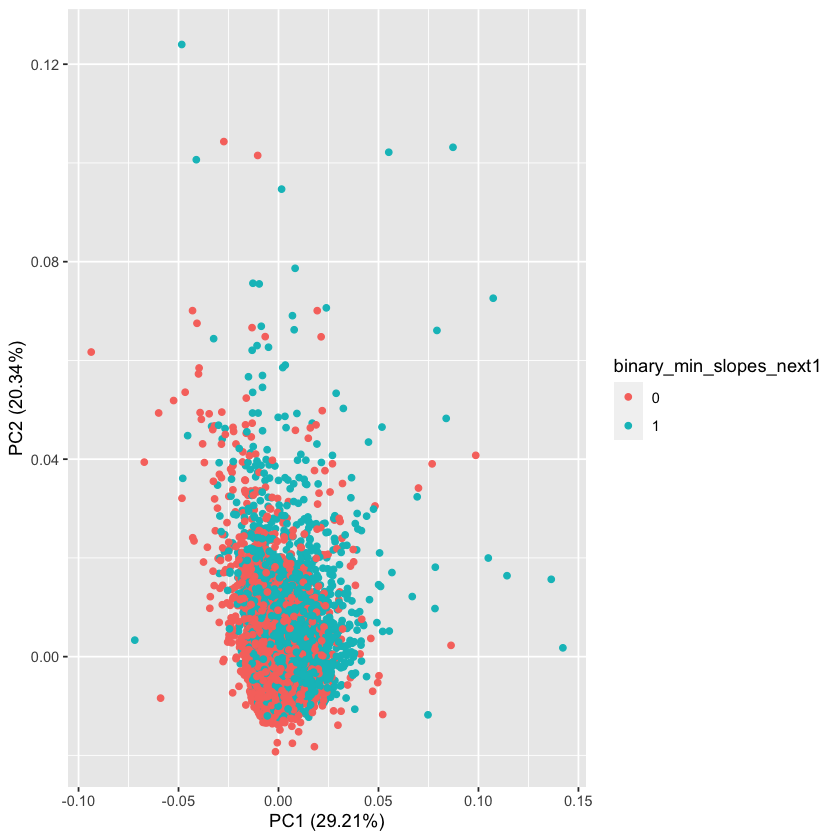

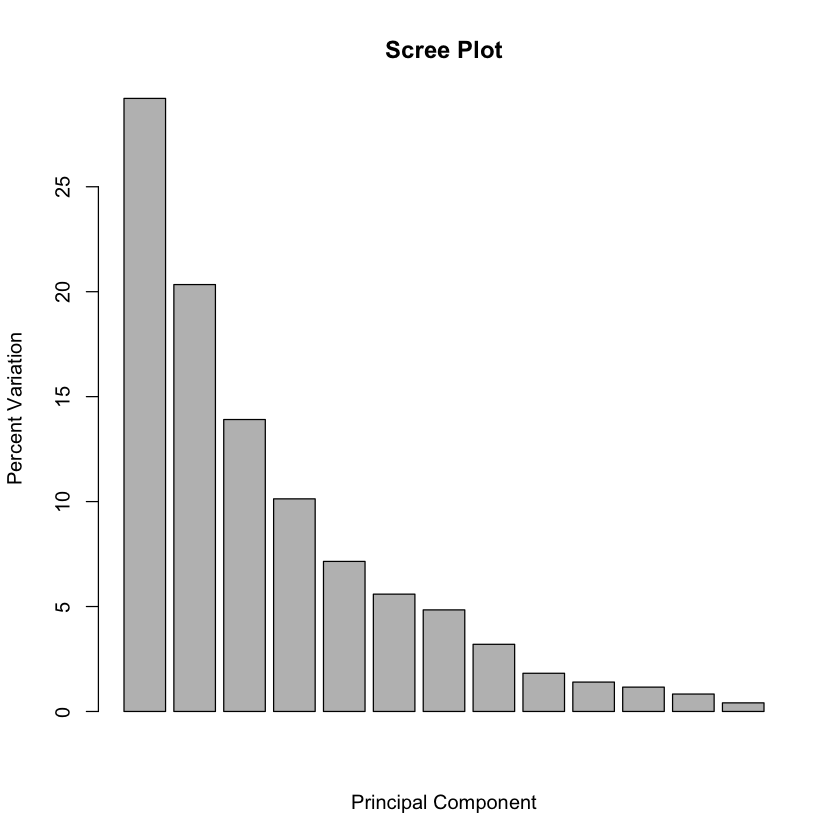

In [36]:
# Perform PCA on the data before all amounts removal
pca_results <- prcomp(binary_outcome_min_max_df[,c(10,13:24)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_min_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

Standard deviations (1, .., p=9):
[1] 1.5079923 1.2884423 1.2274343 0.9804802 0.9360878 0.7935809 0.7644359
[8] 0.5469667 0.4564790

Rotation (n x k) = (9 x 9):
                               PC1        PC2           PC3         PC4
local_min_slopes_next1  0.25472171 -0.1362972  0.1759372658 -0.82318445
min_to_max_slopes       0.28541871 -0.2057344  0.5318513960  0.07320314
max_to_min_slopes      -0.10534512 -0.1312984 -0.6454237782 -0.18238913
min_to_max_dists        0.52588128  0.1136370 -0.2370901759 -0.06979058
max_to_min_dists        0.06965597  0.3471203  0.3778799660  0.06598220
local_max_slopes        0.36760128 -0.5432931 -0.1149094552  0.01268850
local_min_slopes        0.27303155 -0.4500038 -0.0003979258  0.45755837
local_max_dists         0.49114014  0.4160536 -0.1075187061 -0.02476985
local_min_dists         0.33204936  0.3430451 -0.2140997055  0.25374057
                               PC5         PC6          PC7         PC8
local_min_slopes_next1  0.04059639 -0.29378920 

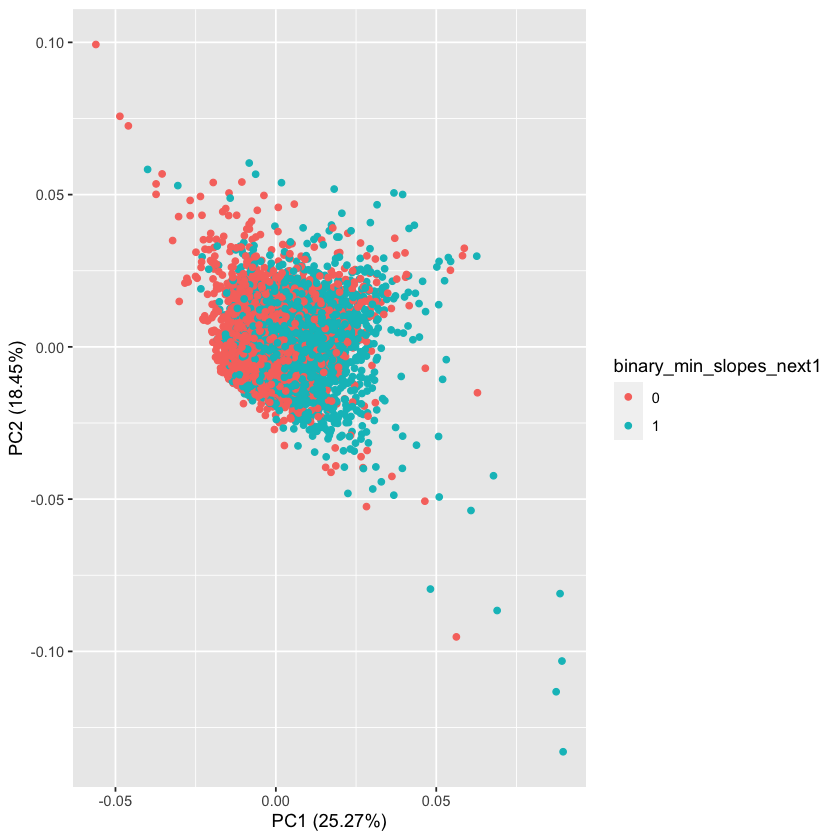

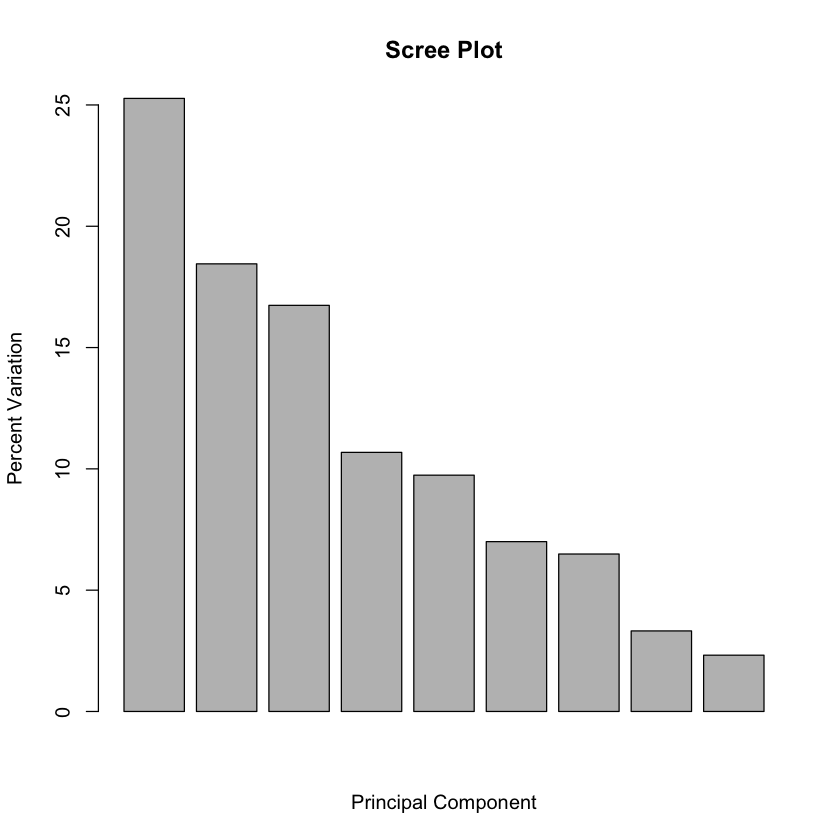

In [37]:
# Perform PCA on the data after all amounts removal
pca_results <- prcomp(binary_outcome_min_max_df[,c(10,15:18,21:24)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_min_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

In [38]:
# My hypothesis was wrong. Removing all 'amounts' variables negatively impacted the model. Trying again with only 
# removing local_min_amounts

Standard deviations (1, .., p=12):
 [1] 1.8557823 1.6126053 1.3161391 0.9898900 0.9626405 0.8125948 0.7836100
 [8] 0.6329257 0.4830729 0.4235714 0.3885998 0.2793979

Rotation (n x k) = (12 x 12):
                               PC1         PC2          PC3          PC4
local_min_slopes_next1  0.21044004  0.05726535  0.074507534 -0.697212791
min_to_max_amounts      0.46051911  0.15909404  0.061764891 -0.118677781
max_to_min_amounts     -0.01748364 -0.55992918 -0.157224921 -0.135649700
min_to_max_slopes       0.29743998  0.23406433  0.331398466 -0.135846827
max_to_min_slopes      -0.07468988 -0.44461188 -0.253331725  0.009046484
min_to_max_dists        0.36042028  0.02707459 -0.410336116 -0.018059831
max_to_min_dists       -0.02091255  0.42164405 -0.008782115  0.300514981
local_max_amounts       0.42737809 -0.27773643  0.134426207  0.073363314
local_max_slopes        0.42211144 -0.27153082  0.173496691  0.096032480
local_min_slopes        0.27621252 -0.12681976  0.202764965  0.585692212
l

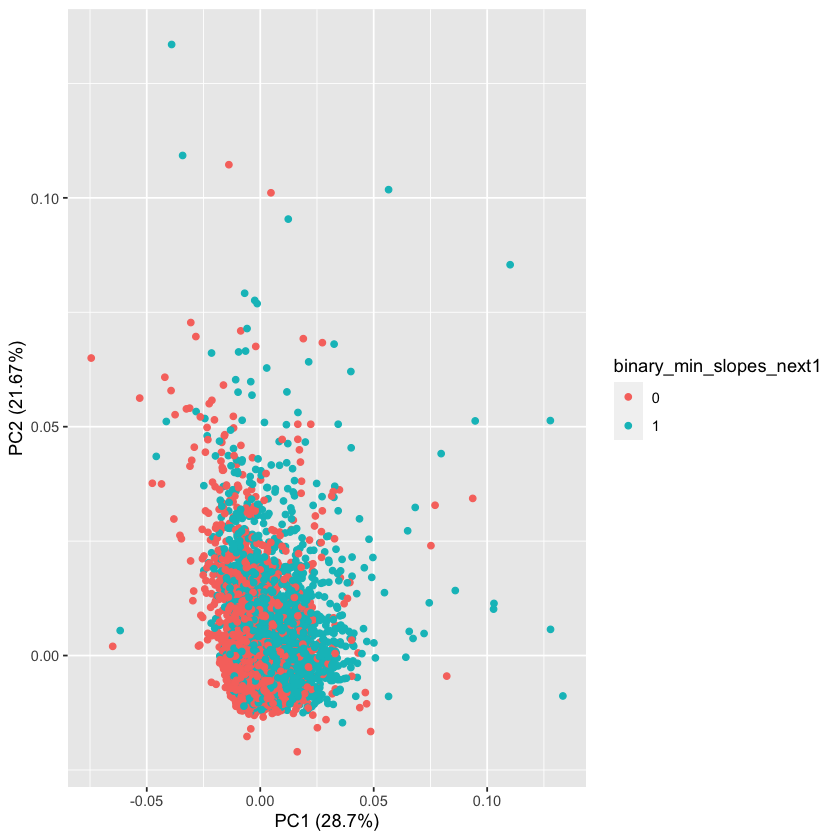

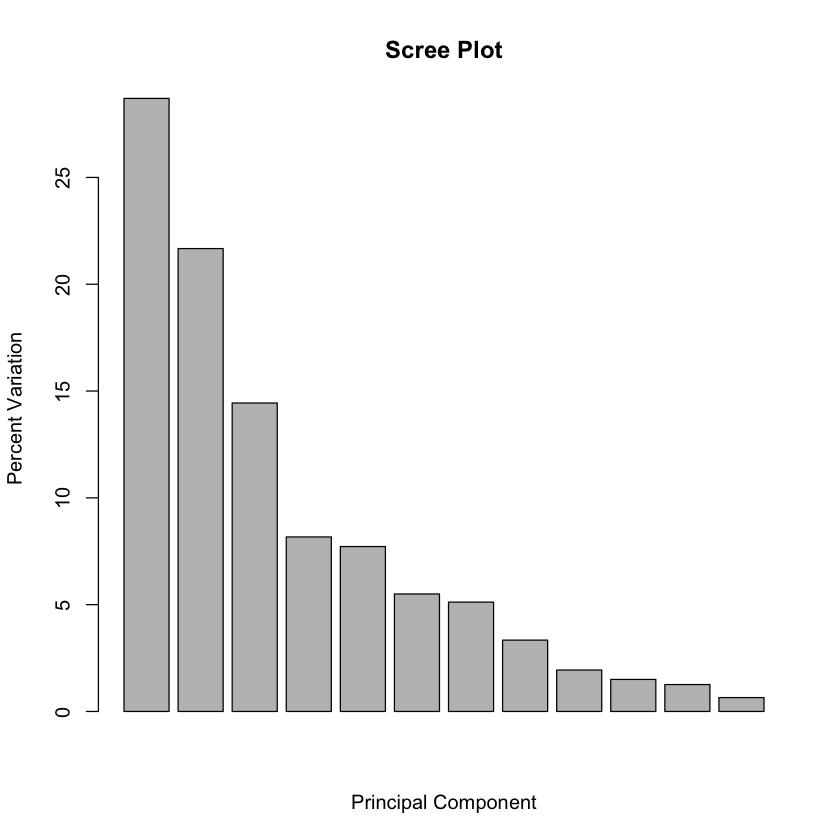

In [39]:
# Perform PCA on the data after local_min_amounts removal
pca_results <- prcomp(binary_outcome_min_max_df[,c(10,13:19,21:24)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_min_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

In [40]:
# Still not as good as first pca

Standard deviations (1, .., p=11):
 [1] 1.8556432 1.4010654 1.2636304 0.9807186 0.9452383 0.8125115 0.7812989
 [8] 0.6200821 0.4772624 0.4221740 0.2836248

Rotation (n x k) = (11 x 11):
                               PC1         PC2         PC3          PC4
local_min_slopes_next1  0.20961392  0.03946378  0.13542063  0.808873074
min_to_max_amounts      0.45819623  0.14754885  0.18918932  0.022976259
min_to_max_slopes       0.29385927  0.10520691  0.50442309 -0.073044422
max_to_min_slopes      -0.06789834 -0.31857722 -0.53002346  0.186805245
min_to_max_dists        0.36046843  0.22723546 -0.35078734  0.068218196
max_to_min_dists       -0.02735283  0.37962720  0.20705017 -0.097006788
local_max_amounts       0.43113565 -0.34149198 -0.07464571 -0.004007853
local_max_slopes        0.42570868 -0.35666535 -0.03906221 -0.019793448
local_min_slopes        0.27751724 -0.25331284  0.04163292 -0.478400959
local_max_dists         0.24653262  0.49204129 -0.31956735  0.017775887
local_min_dists       

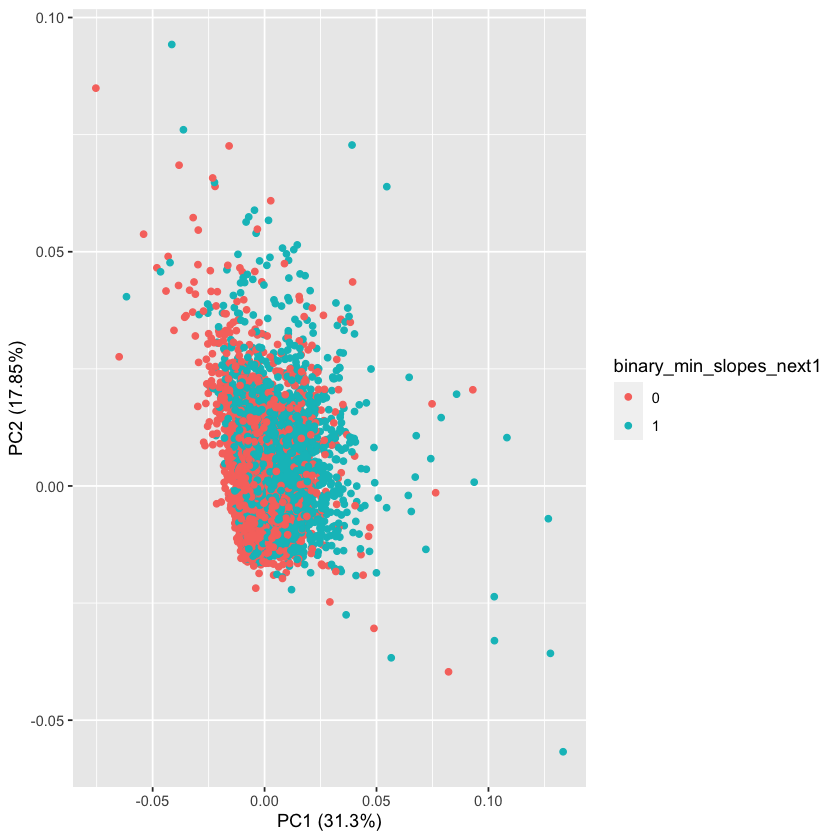

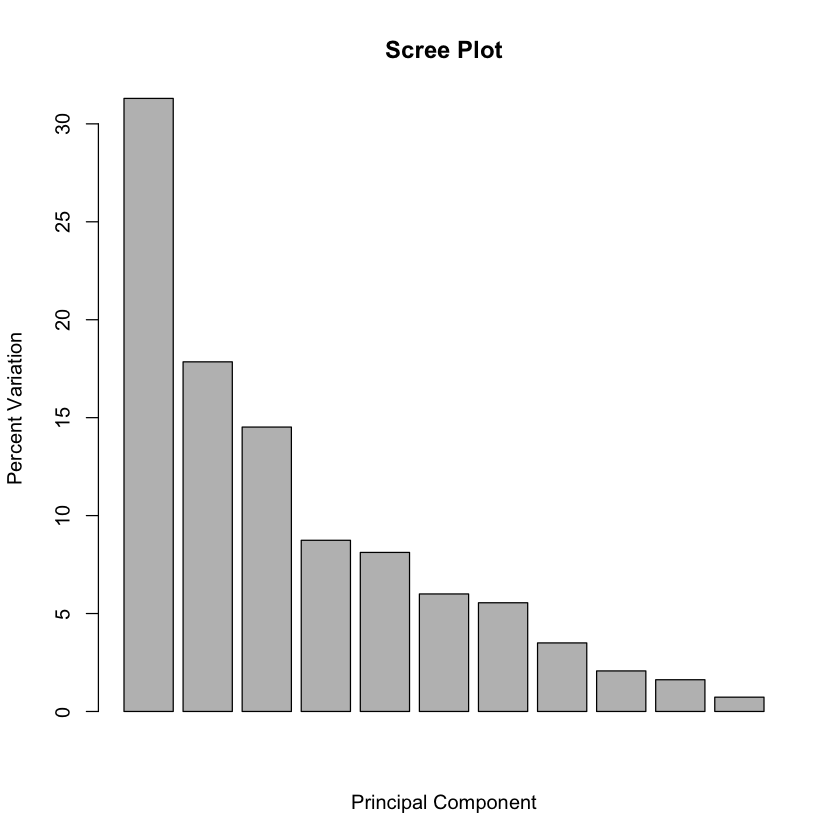

In [41]:
# Perform PCA on the data after local_min_amounts and min_to_max_amounts removal
pca_results <- prcomp(binary_outcome_min_max_df[,c(10,13,15:19,21:24)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_min_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

In [42]:
# Slightly better than first PCA

Standard deviations (1, .., p=9):
[1] 1.7811039 1.4681115 1.1505085 0.9238839 0.8366726 0.5693523 0.4546087
[8] 0.4266861 0.2866581

Rotation (n x k) = (9 x 9):
                                PC1         PC2         PC3         PC4
local_min_slopes_next1  0.240702232  0.07393891  0.11879644 -0.95794915
min_to_max_amounts      0.484976229  0.16881631  0.11394690  0.13787709
max_to_min_amounts      0.002497445 -0.59747068 -0.22631228 -0.05419233
min_to_max_slopes       0.309940344  0.21309452  0.50502594  0.20698507
min_to_max_dists        0.382368034  0.08011846 -0.54267314  0.05778126
max_to_min_dists       -0.035267897  0.54316356  0.05121096  0.01536859
local_max_amounts       0.449659436 -0.29466083  0.09758329  0.08058889
local_max_slopes        0.442109821 -0.27885381  0.16598550  0.08467609
local_max_dists         0.256295528  0.31244765 -0.57658016  0.01744210
                               PC5         PC6         PC7          PC8
local_min_slopes_next1  0.05488900 -0.01255665 

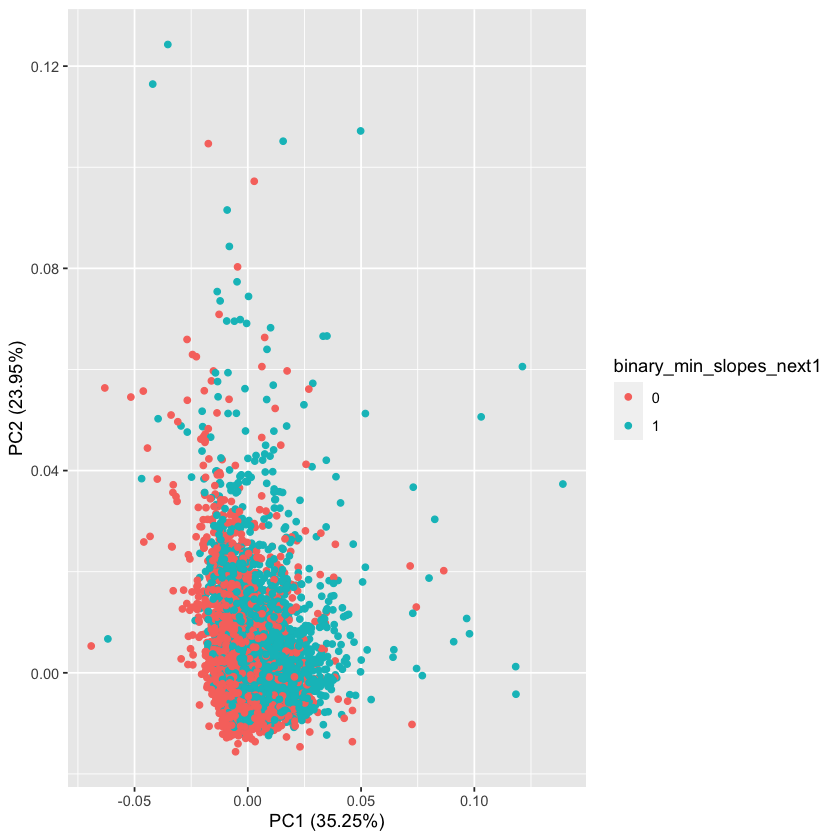

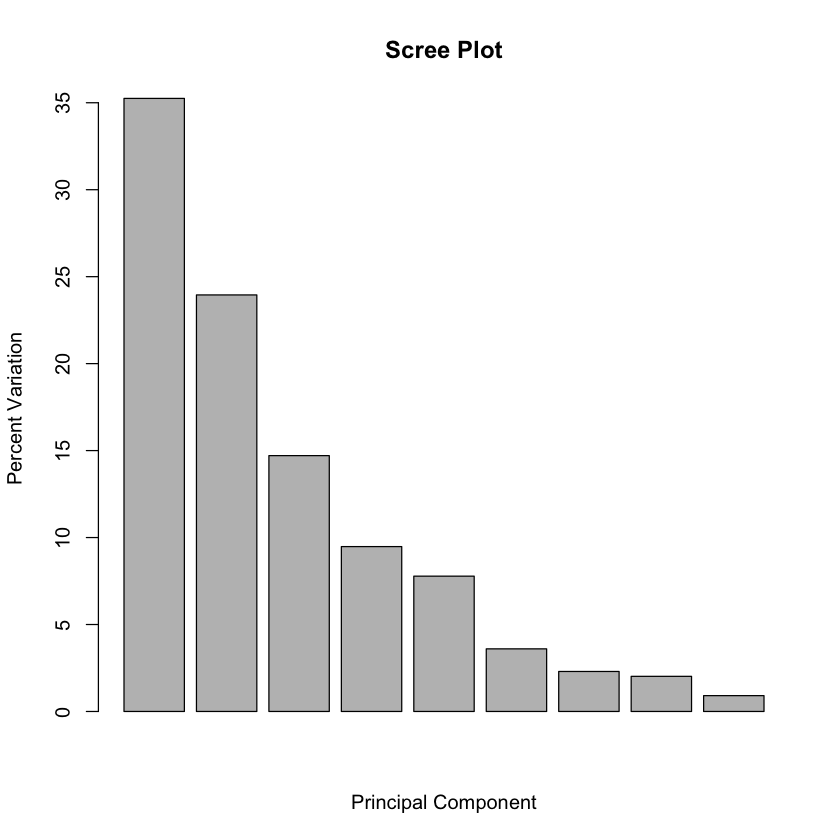

In [43]:
# Perform PCA on the data (Optimal Version)
pca_results <- prcomp(binary_outcome_min_max_df[,c(10,13:15,17:19,21,23)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_min_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

Standard deviations (1, .., p=9):
[1] 1.8483009 1.2941311 1.1193481 1.0050784 0.8887458 0.6467941 0.5192136
[8] 0.3334785 0.2385027

Rotation (n x k) = (9 x 9):
                               PC1        PC2         PC3         PC4
local_max_slopes_next1  0.09346841  0.1549822 -0.61313126 -0.09211209
min_to_max_amounts      0.37892774 -0.4181341  0.09150071 -0.06439513
min_to_max_slopes       0.27137161 -0.5494792 -0.05907585 -0.15840757
max_to_min_slopes      -0.04495158  0.5589606  0.41207447 -0.15661794
local_max_amounts       0.46003414  0.1157132  0.28372290 -0.21235115
local_min_amounts       0.41703811  0.2756635 -0.26136103  0.30467789
local_max_slopes        0.45881235  0.1079061  0.29559594 -0.24305816
local_min_slopes        0.41725031  0.2556000 -0.27673040  0.27805165
local_min_dists         0.04307495 -0.1429166  0.36005195  0.81451512
                               PC5         PC6          PC7          PC8
local_max_slopes_next1  0.74964946  0.07520244 -0.123066010  0.003

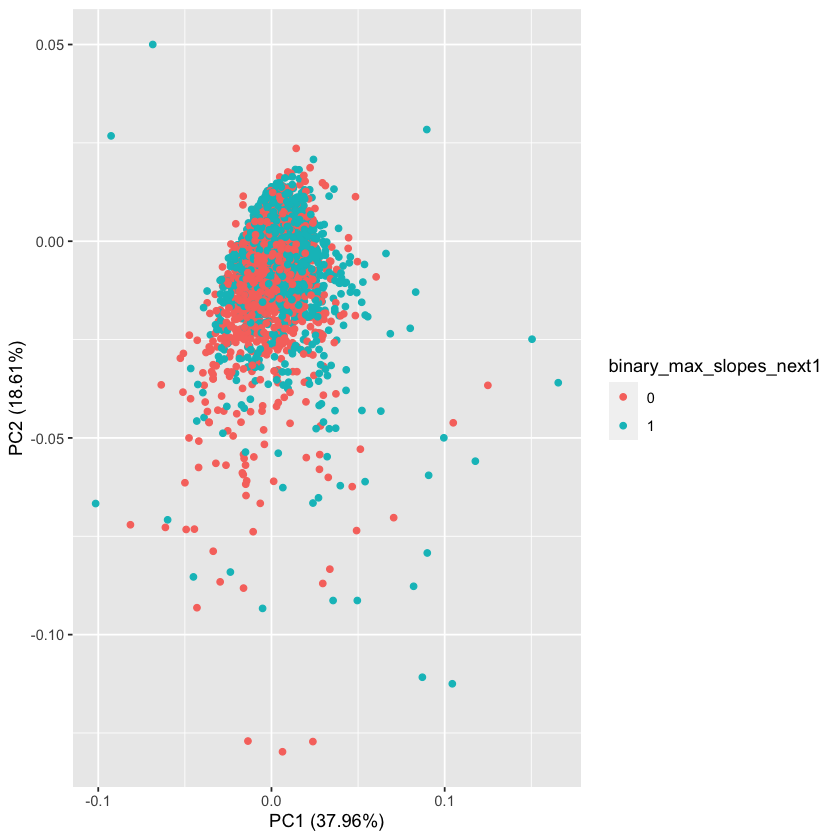

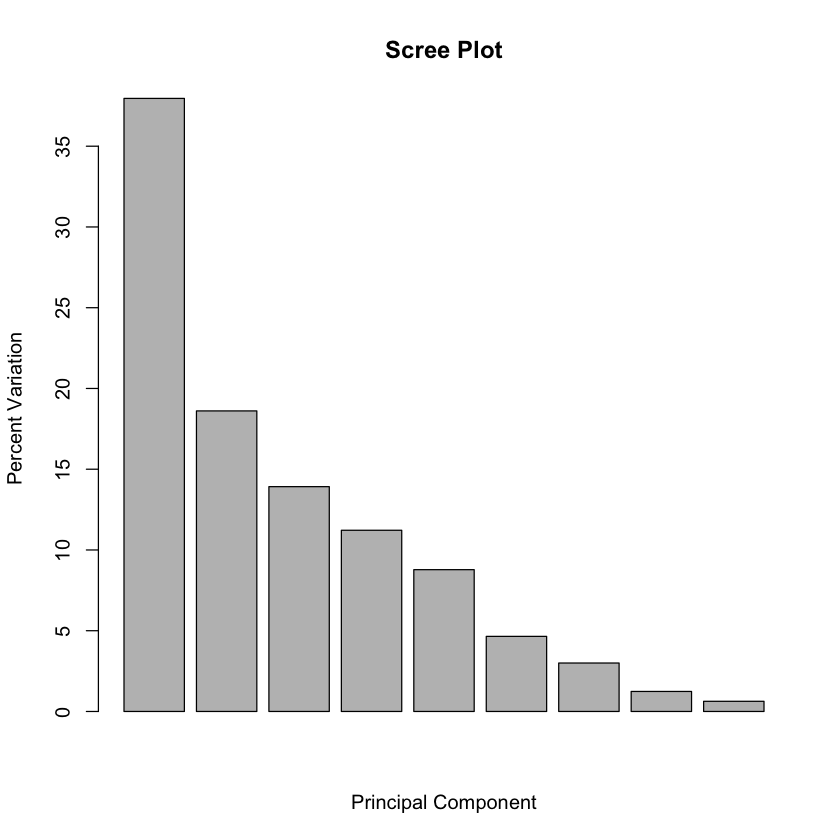

In [44]:
# Perform PCA on the data for local_max_slopes_next1 binary target var
pca_results <- prcomp(binary_outcome_min_max_df[,c(9,13,15:16,19:22,24)], scale = TRUE)

# Print the results
pca_results

# Plot the results
autoplot(pca_results, data=binary_outcome_min_max_df, colour='binary_max_slopes_next1')

# Plot variance percent for principal components
pca_var <- pca_results$sdev^2
pca_var_pct <- round(pca_var/sum(pca_var)*100,2)
barplot(pca_var_pct, main ='Scree Plot', xlab='Principal Component', ylab='Percent Variation')

In [45]:
# Splitting data into train and test sets
set.seed(3456)
train_idxs <- runif(floor(nrow(binary_outcome_min_max_df) * .2),
                    1, nrow(binary_outcome_min_max_df) )
train_data <- binary_outcome_min_max_df[c(train_idxs),]
test_data <- binary_outcome_min_max_df[-c(train_idxs),]

# Training the models
glm.fit_min_slopes <- glm(binary_min_slopes_next1 ~ local_max_slopes+ local_max_amounts+ local_max_dists+
                          min_to_max_dists+ min_to_max_amounts+ min_to_max_slopes+
                          max_to_min_amounts+ max_to_min_dists,
                data = train_data, family = binomial)
summary(glm.fit_min_slopes)

# Testing the model
test_probs_min_slopes <- predict(glm.fit_min_slopes,
                      newdata = test_data,
                      type = "response")
test_preds_min_slopes <- ifelse(test_probs_min_slopes > 0.5, 1, 0)
confusion_matrix_min_slopes <- table(test_preds_min_slopes, test_data$binary_min_slopes_next1)
confusion_matrix_min_slopes
accuracy_min_slopes <- sum(diag(confusion_matrix_min_slopes))/sum(confusion_matrix_min_slopes)
accuracy_min_slopes

# Training the Max Slopes model
glm.fit_max_slopes <- glm(binary_max_slopes_next1 ~ local_min_slopes+ local_min_dists+ local_min_amounts+
                          min_to_max_slopes + min_to_max_amounts+
                          max_to_min_slopes+ max_to_min_dists+ 
                          local_max_slopes,
                data = train_data, family = binomial)
summary(glm.fit_max_slopes)

# Testing the model
test_probs_max_slopes <- predict(glm.fit_max_slopes,
                      newdata = test_data,
                      type = "response")
test_preds_max_slopes <- ifelse(test_probs_max_slopes > 0.5, 1, 0)
confusion_matrix_max_slopes <- table(test_preds_max_slopes, test_data$binary_max_slopes_next1)
confusion_matrix_max_slopes
accuracy_max_slopes <- sum(diag(confusion_matrix_max_slopes))/sum(confusion_matrix_max_slopes)
accuracy_max_slopes


Call:
glm(formula = binary_min_slopes_next1 ~ local_max_slopes + local_max_amounts + 
    local_max_dists + min_to_max_dists + min_to_max_amounts + 
    min_to_max_slopes + max_to_min_amounts + max_to_min_dists, 
    family = binomial, data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1698  -1.1427   0.7319   1.1233   1.6796  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.461773   0.122842  -3.759 0.000171 ***
local_max_slopes     0.863376 149.783518   0.006 0.995401    
local_max_amounts   23.767146  13.101787   1.814 0.069672 .  
local_max_dists      0.039604   0.012902   3.070 0.002144 ** 
min_to_max_dists     0.021200   0.020204   1.049 0.294031    
min_to_max_amounts  15.035421  19.056290   0.789 0.430112    
min_to_max_slopes   66.716190  89.847367   0.743 0.457754    
max_to_min_amounts  -9.768569  10.838198  -0.901 0.367424    
max_to_min_dists    -0.004737   0.016948  -0.280 0.779859

                     
test_preds_min_slopes    0    1
                    0 1721 1194
                    1 1479 2441

[1] 0.6089247


Call:
glm(formula = binary_max_slopes_next1 ~ local_min_slopes + local_min_dists + 
    local_min_amounts + min_to_max_slopes + min_to_max_amounts + 
    max_to_min_slopes + max_to_min_dists + local_max_slopes, 
    family = binomial, data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1288  -1.2205   0.8862   1.0479   2.0850  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         8.469e-01  1.256e-01   6.742 1.57e-11 ***
local_min_slopes   -5.858e+01  1.616e+02  -0.362 0.717026    
local_min_dists    -6.415e-02  8.635e-03  -7.429 1.09e-13 ***
local_min_amounts   4.340e+01  1.284e+01   3.379 0.000728 ***
min_to_max_slopes  -8.677e+01  8.106e+01  -1.070 0.284436    
min_to_max_amounts  2.481e+01  1.195e+01   2.076 0.037869 *  
max_to_min_slopes   6.012e+01  6.501e+01   0.925 0.355072    
max_to_min_dists    8.162e-03  1.243e-02   0.656 0.511551    
local_max_slopes   -1.866e+02  9.191e+01  -2.030 0.042383 

                     
test_preds_max_slopes    0    1
                    0 1204  695
                    1 1949 2987

[1] 0.6131675

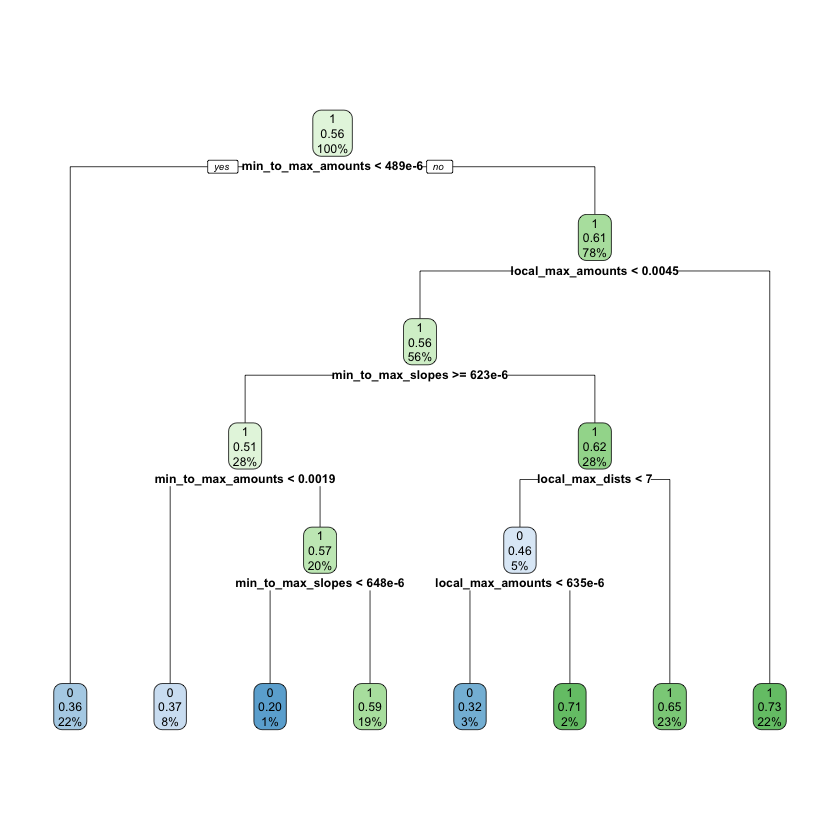

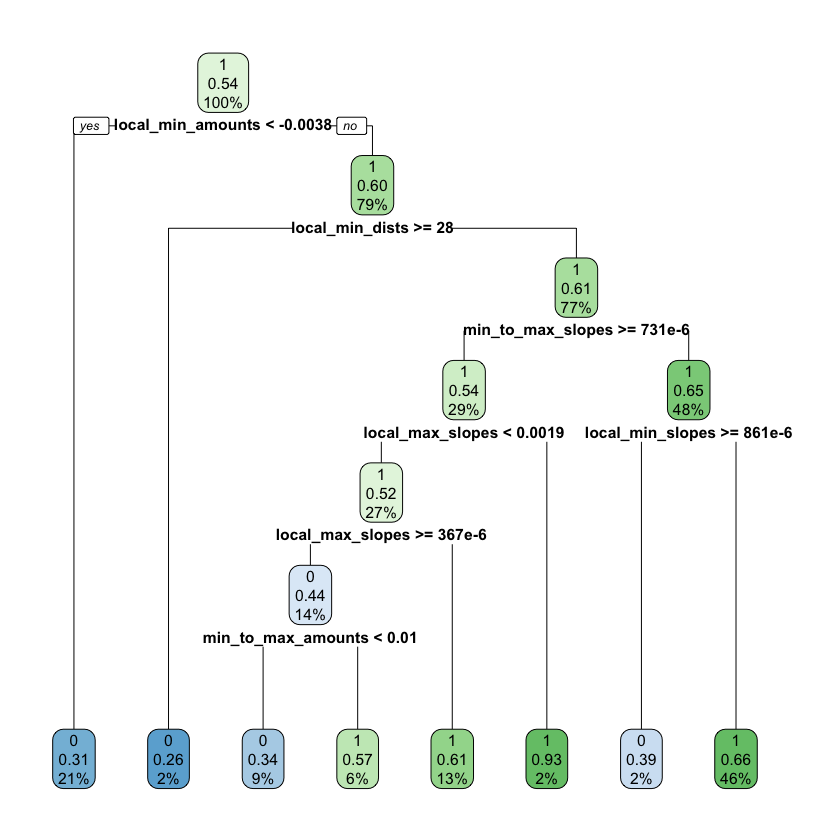

In [46]:
# Decision Tree
tree_min_slopes <- rpart(binary_min_slopes_next1 ~ local_max_slopes+ local_max_amounts+ local_max_dists+
                          min_to_max_dists+ min_to_max_amounts+ min_to_max_slopes+
                          max_to_min_amounts+ max_to_min_dists,
                      train_data)
rpart.plot(tree_min_slopes)

tree_max_slopes <- rpart(binary_max_slopes_next1 ~ local_min_slopes+ local_min_dists+ local_min_amounts+
                          min_to_max_slopes + min_to_max_amounts+
                          max_to_min_slopes+ max_to_min_dists+ 
                          local_max_slopes,
                        train_data)
rpart.plot(tree_max_slopes)

In [47]:
pred_min_slopes = predict(tree_min_slopes, test_data, type='class')
confusion_matrix_min_slopes <- table(pred_min_slopes, test_data$binary_min_slopes_next1)
confusion_matrix_min_slopes
accuracy_min_slopes <- sum(diag(confusion_matrix_min_slopes))/sum(confusion_matrix_min_slopes)
accuracy_min_slopes

pred_max_slopes = predict(tree_max_slopes, test_data, type='class')
confusion_matrix_max_slopes <- table(pred_max_slopes, test_data$binary_max_slopes_next1)
confusion_matrix_max_slopes
accuracy_max_slopes <- sum(diag(confusion_matrix_max_slopes))/sum(confusion_matrix_max_slopes)
accuracy_max_slopes

               
pred_min_slopes    0    1
              0 1420  946
              1 1780 2689

[1] 0.6011704

               
pred_max_slopes    0    1
              0 1341 1001
              1 1812 2681

[1] 0.5884418

[1] "Balance after 1 Years:  $ 16587.53"
[1] "Balance after 2 Years:  $ 28892.05"
[1] "Balance after 3 Years:  $ 46209.04"
[1] "Balance after 4 Years:  $ 76270.01"
[1] "Balance after 5 Years:  $ 114527.38"
[1] "Balance after 6 Years:  $ 164387.63"
[1] "Balance after 7 Years:  $ 231608.83"
[1] "Balance after 8 Years:  $ 361621.46"
[1] "Balance after 9 Years:  $ 477986.08"
[1] "Balance after 10 Years:  $ 668318.04"
[1] "Balance after 11 Years:  $ 1056142.49"
[1] "Balance after 12 Years:  $ 1402543.2"
[1] "Balance after 13 Years:  $ 2835501.86"
[1] "Balance after 14 Years:  $ 4104918.66"
[1] "Balance after 14.6 Years:  $ 5120050.26"


Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


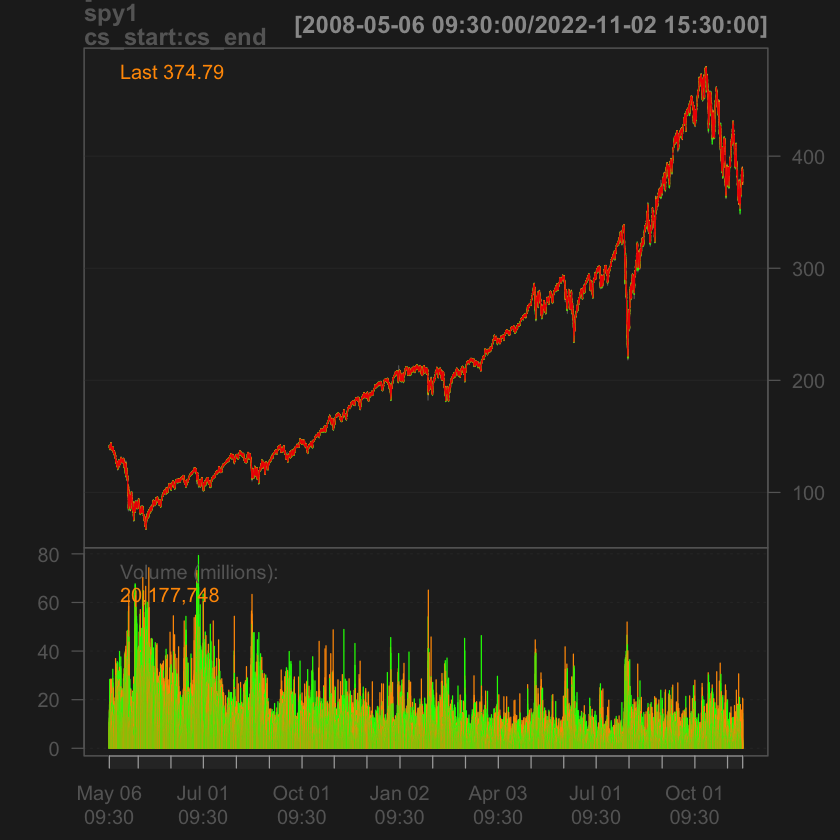

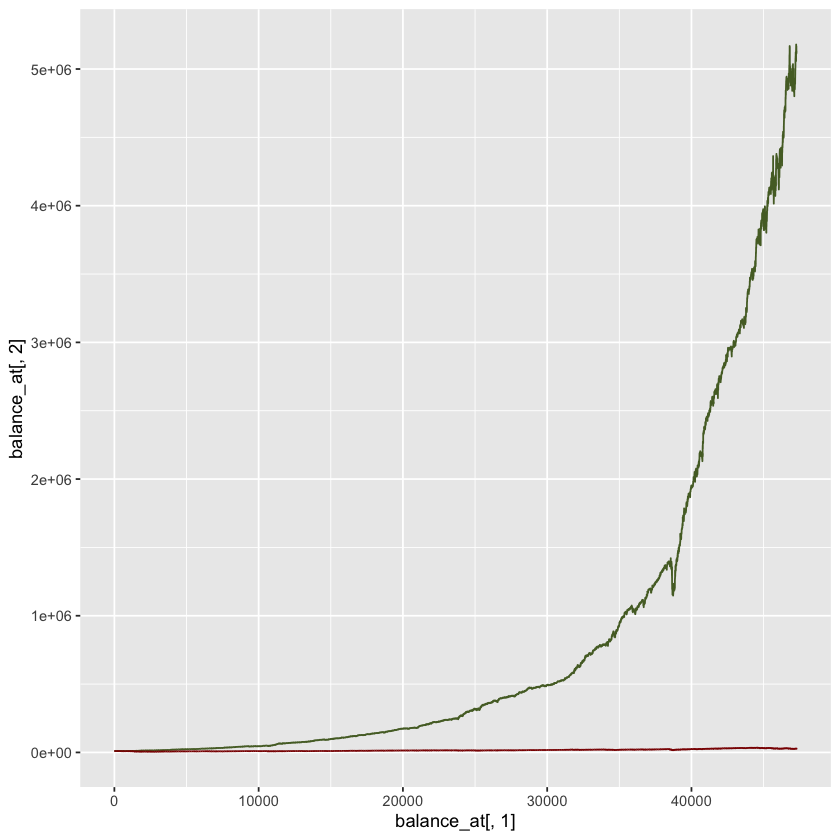

In [130]:
##### Simulation of the model on the market as it goes
# This takes about 10 minutes to run

# Starting balance
start_balance <- 10000
total_balance <- start_balance
unused_balance <- total_balance

total_shares <- 0
last_buy_idx <- 62 # Can only do like this bc i know it starts on a buy signal

# Vector for the Profit/Loss of each trade
trades_pl <- c()

# Vector for the balance at the end of each candle
eod_balances <- c()

# Stop loss
stop_loss <- .98

# Vector for the P/L % for each trade
trades_pl_pct <- c()

# Matrix to be used for plotting balance of account vs. market
balance_at <- matrix(nrow = 1, ncol = 3)

# Start and end of second loop, dynamically sized to speed up the runtime
start_j <- 1
end_j <- 20

for (i in 1:N) {
  for (j in start_j:end_j) {

    # Lagged by 2 bc wont know the signal till 2 candles have passed
    if (i-2 == min_max_df$local_mins[j]){
      
      test_probs <- predict(glm.fit_min_slopes, newdata = binary_outcome_min_max_df[j,], type = "response")
      test_preds <- ifelse(test_probs > 0.5, 1, 0)
      
      if (test_preds == 1) {
        #print(paste('BUY @',i-2))
        start_j <- j
        # dynamically adjust end of loop to be 200 away from last j
        if(end_j+j<nrow(min_max_df)){
          end_j = end_j + j
        } else {
          end_j = nrow(min_max_df)
        }
        #print(test_preds)
        shares_to_buy <- floor(unused_balance / spy_reversed$Close[i])
        #print(paste('BUY @', i-2, '  Shares bought:',shares_to_buy))
        last_buy_price <- spy_reversed$Close[i]
        if (total_shares==0) {
          last_buy_idx <- i
        }
        total_shares <- total_shares + shares_to_buy
        unused_balance <- unused_balance - (shares_to_buy * spy_reversed$Close[i])
        total_balance <- unused_balance + (total_shares*spy_reversed$Close[i])

      }
    # Sell, lagged by 2 bc wont know the local max till 2 candles have passed
    } else if (i-2 == min_max_df$local_maxs[j] && total_shares>0){
        
      test_probs <- predict(glm.fit_max_slopes, newdata = binary_outcome_min_max_df[j,], type = "response")
      test_preds <- ifelse(test_probs > 0.5, 1, 0)
        if (test_preds==0) {
      
          #print('Sell located')
          profit_loss <- (spy_reversed$Close[i] - spy_reversed$Close[last_buy_idx]) * total_shares
          #print(paste('Sell @', i,  ' Shares sold:', total_shares, '   P/L:', profit_loss) )
          total_balance <- (spy_reversed$Close[i] * total_shares) + unused_balance
          unused_balance <- total_balance
          trades_pl <- append(trades_pl, profit_loss)
          total_shares <- 0
      
          trades_pl_pct <- append(trades_pl_pct, ((spy_reversed$Close[i] - spy_reversed$Close[last_buy_idx]) / spy_reversed$Close[last_buy_idx]))
          stop_loss <- .98
        }
    }
  } # When to Sell
  if (spy_reversed$Close[i] < spy_reversed$Close[last_buy_idx]*stop_loss & total_shares>0) {
      
      profit_loss <- (spy_reversed$Close[i] - spy_reversed$Close[last_buy_idx]) * total_shares
      #print(paste('Sell @', i,  ' Shares sold:', total_shares, '   P/L:', profit_loss) )
      total_balance <- (spy_reversed$Close[i] * total_shares) + unused_balance
      unused_balance <- total_balance
      trades_pl <- append(trades_pl, profit_loss)
      total_shares <- 0
        
      trades_pl_pct <- append(trades_pl_pct, ((spy_reversed$Close[i] - spy_reversed$Close[last_buy_idx]) / spy_reversed$Close[last_buy_idx]))
      stop_loss <- .98
  
  # Move stop loss amount up if these thresholds are crossed while holding shares
  } else if (total_shares>0){
      if (spy_reversed$Close[i]>spy_reversed$Close[last_buy_idx]*1.03){
        stop_loss<-1.03
      }
      if (spy_reversed$Close[i]>spy_reversed$Close[last_buy_idx]*1.07){
        stop_loss<-1.07
      }
      total_balance <- unused_balance + (total_shares*spy_reversed$Close[i])
    }
  else {
      total_balance <- unused_balance + (total_shares*spy_reversed$Close[i])
    }
    balance_at <- rbind(balance_at, c(i, total_balance, spy_reversed$Close[i]*72))
    eod_balances <- append(eod_balances, total_balance)
    #print(paste('Balance:',total_balance))
    
  # 3250 candles = 1 year, print the balance after each year
  if (i%%3250==0) {
    print(paste('Balance after', i/3250, 'Years:  $',round(total_balance,2)))
    #matplot(balance_at, type = "b", pch=1, col = 1:2)
    #title(main=balance_at[i])
  } else if (i==N) {
      print(paste('Balance after', round(i/3250,1), 'Years:  $',round(total_balance,2)))
  }
}

# Plotting the full SPY Chart
cs_start=1
cs_end=47298

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='red2'), addVo()))

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


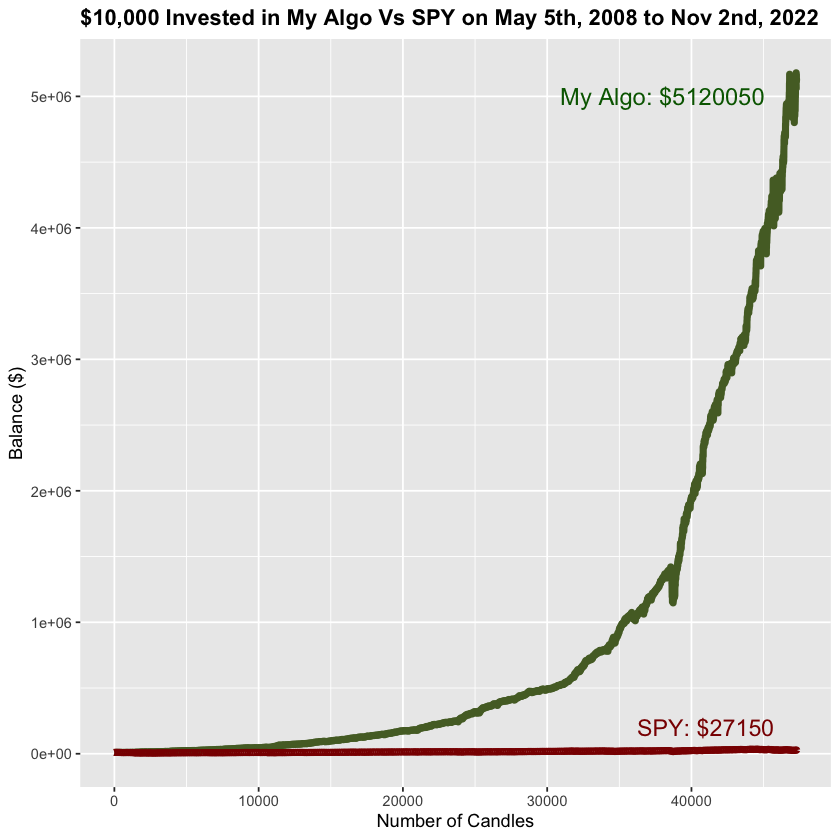

In [169]:
# Plotting the balance of this algo vs SPY over the full length of time (both start at $10,000)
ggplot(balance_at, aes(balance_at[,1])) +
    geom_line(aes(y=balance_at[,2]), col='darkolivegreen',lwd=2) +
    geom_line(aes(y=balance_at[,3]), col='darkred',lwd=2) +
    xlab('Number of Candles') + ylab('Balance ($)') + 
    ggtitle('$10,000 Invested in My Algo Vs SPY on May 5th, 2008 to Nov 2nd, 2022') +
    theme(plot.title=element_text(face='bold')) + 
    annotate(geom="text", x=38000, y=5000000, label=paste('My Algo: $', round(balance_at[47298,2]), sep=''),
              color="darkgreen", cex=5) +
    annotate(geom="text", x=41000, y=200000, label=paste('SPY: $', round(balance_at[47298,3]), sep=''),
              color="darkred", cex=4.9)

In [49]:
# Start to end Total Return %
round(((spy_reversed$Close[47298]-spy_reversed$Close[1])/spy_reversed$Close[1]) * 100,2)

# Maximum possible Total Return %
round(((max(spy_reversed$Close)-min(spy_reversed$Close)) / min(spy_reversed$Close)) * 100,2)

# My Return Total %
round(((total_balance-start_balance)/start_balance) * 100,2)

[1] 167.8

[1] 613.72

[1] 51100.5

In [64]:
num_years <- N / 3500

avg_return_1 <- (spy_reversed$Close[47298] / spy_reversed$Close[1]) ^ (1 / num_years) - 1
print(paste('Buying on first candle and selling on last... Average annual rate of return: ',
            round(avg_return_1*100,2),'%', sep=''))

avg_return_2 <- (max(spy_reversed$Close) / min(spy_reversed$Close)) ^ (1 / (num_years-1)) - 1
print(paste('Buying on lowest candle and selling on highest... Average annual rate of return: ',
            round(avg_return_2*100,2),'%', sep=''))

avg_return <- (total_balance / start_balance) ^ (1 / num_years) - 1
print(paste('My algo... Average annual rate of return: ',round(avg_return*100,2),'%',sep=''))

[1] "Buying on first candle and selling on last... Average annual rate of return: 7.56%"
[1] "Buying on lowest candle and selling on highest... Average annual rate of return: 17.01%"
[1] "My algo... Average annual rate of return: 58.67%"


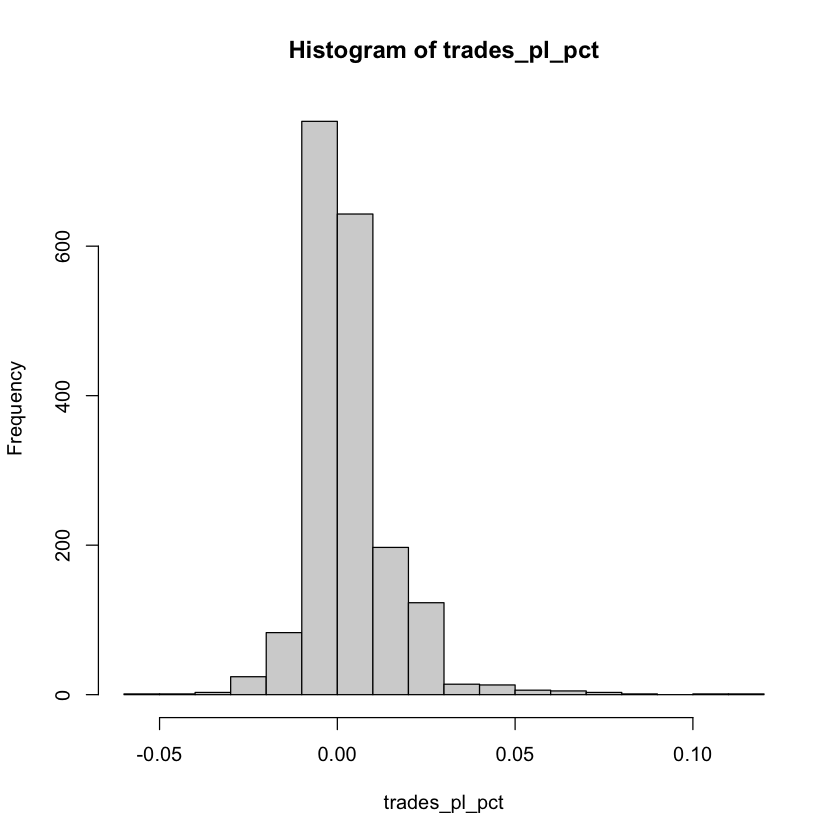

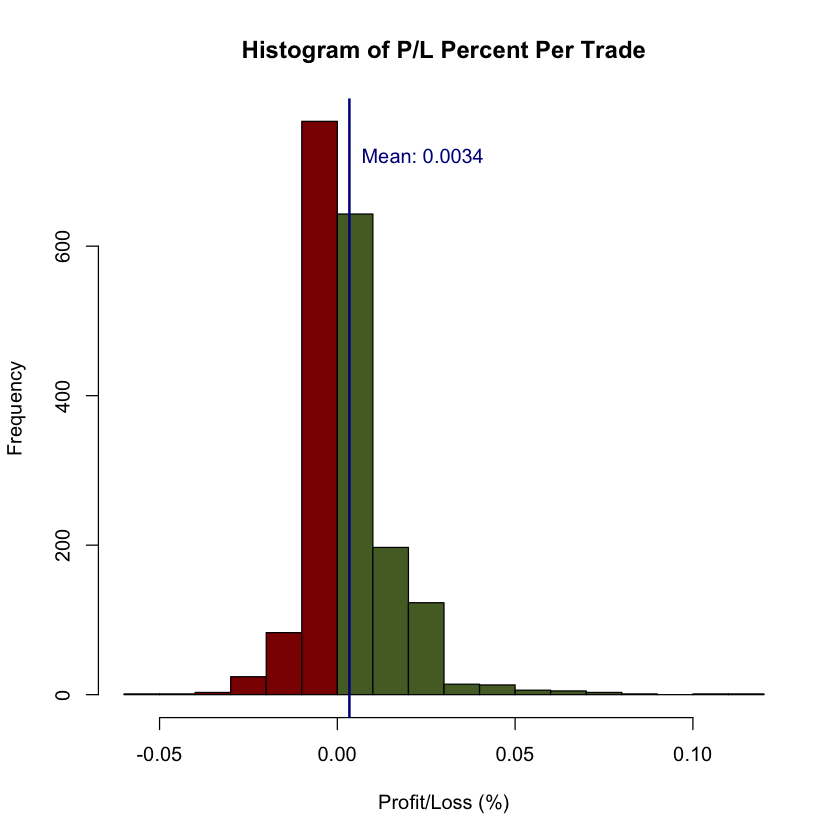

In [142]:
my_breaks<-hist(trades_pl_pct)$breaks
my_colors<- rep('darkolivegreen',length(my_breaks))
my_colors[my_breaks<0] <- 'darkred'
hist(trades_pl_pct, breaks=my_breaks, col=my_colors, main='Histogram of P/L Percent Per Trade', 
     xlab='Profit/Loss (%)')
abline(v=mean(trades_pl_pct), lwd=2, col='darkblue')
text(0,3, paste('Mean:',round(mean(trades_pl_pct),4)), col = 'darkblue', adj = c(-.2, -37))


In [52]:
# Total trades executed
length(trades_pl)

[1] 1886

In [53]:
# Data from Averageannualreturn.com for average annual returns of top S&P500 stocks 12/10/12 - 12/09/22

tickers <- c('SPY','AAPL','MSFT','AMZN','BRK.B','GOOG','UNH','TSLA','NVDA','MA','HD','NFLX','AVGO','MY.ALGO')
avg_returns <- c(12.72,23.93,26.97,21.67,13.38,14.83,27.64,54.24,50.15,22.62,20.35,38.52,35.35,round(avg_return*100,2))

avg_ann_returns <- data.frame(tickers = tickers, avg_returns = avg_returns)
avg_ann_returns

tickers avg_returns
1  SPY     12.72      
2  AAPL    23.93      
3  MSFT    26.97      
4  AMZN    21.67      
5  BRK.B   13.38      
6  GOOG    14.83      
7  UNH     27.64      
8  TSLA    54.24      
9  NVDA    50.15      
10 MA      22.62      
11 HD      20.35      
12 NFLX    38.52      
13 AVGO    35.35      
14 MY.ALGO 58.67

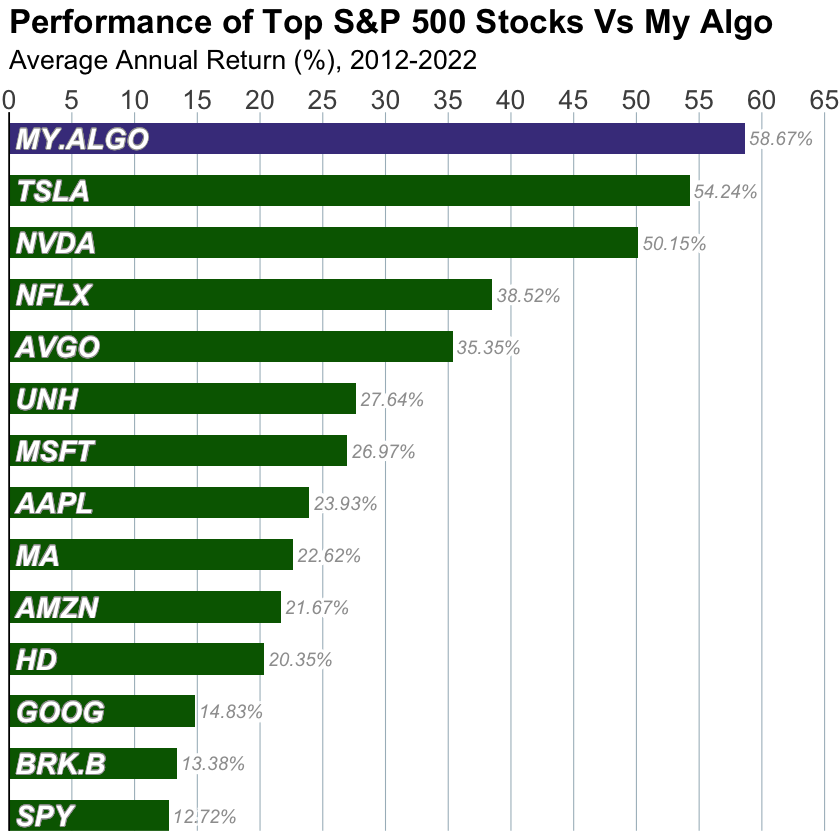

In [61]:
# Barplot of average annual return by ticker vs this algo
fill_colors <- c(rep(8,nrow(avg_ann_returns)-1),16)

avg_ann_returns  %>% 
mutate(tickers = fct_reorder(tickers, avg_returns )) %>%
ggplot(aes(avg_returns,tickers, fill=fill_colors)) + 
    scale_fill_gradient(low="darkgreen", high="darkslateblue") +
  geom_bar(stat = "identity", width=0.6) + 
  scale_x_continuous(
    limits = c(0, 65.5),
    breaks = seq(0, 65, by = 5), 
    expand = c(0, 0), # The horizontal axis does not extend to either side
    position = "top"  # Labels are located on the top
  ) +
  # The vertical axis only extends upwards 
  scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
  theme(
    # Set background color to white
    panel.background = element_rect(fill = "white"),
    # Set the color and the width of the grid lines for the horizontal axis
    panel.grid.major.x = element_line(color = "#A8BAC4", size = 0.3),
    # Remove tick marks by setting their length to 0
    axis.ticks.length = unit(0, "mm"),
    # Remove the title for both axes
    axis.title = element_blank(),
    # Only left line of the vertical axis is painted in black
    axis.line.y.left = element_line(color = "black"),
    # Remove labels from the vertical axis
    axis.text.y = element_blank(),
    # But customize labels for the horizontal axis
    axis.text.x = element_text(size = 16),
    # Remove legend
    legend.position = "none"
  )+ 
  geom_shadowtext(
    data = avg_ann_returns,
    aes(0, y = tickers, label = tickers),
    hjust = 0,
    nudge_x = 0.5,
    colour = "white",
    bg.colour = fill_colors,
    bg.r = 0.04,
    fontface="bold.italic",
    size = 6
  )+ 
  geom_shadowtext(
    data = avg_ann_returns,
    aes(avg_returns, y = tickers, label = paste(avg_returns,'%',sep='')),
    hjust = 0,
    nudge_x = 0.3,
    colour = fill_colors,
    bg.colour = "white",
    bg.r = 0.27,
    fontface="italic",
    size = 4
  )+
  labs(
    title = "Performance of Top S&P 500 Stocks Vs My Algo",
    subtitle = "Average Annual Return (%), 2012-2022"
  ) + 
  theme(
    plot.title = element_text(
      face = "bold",
      size = 20
    ),
    plot.subtitle = element_text(
      size = 16
    )
  )

[1] 39640 13435 12715 38785 34887

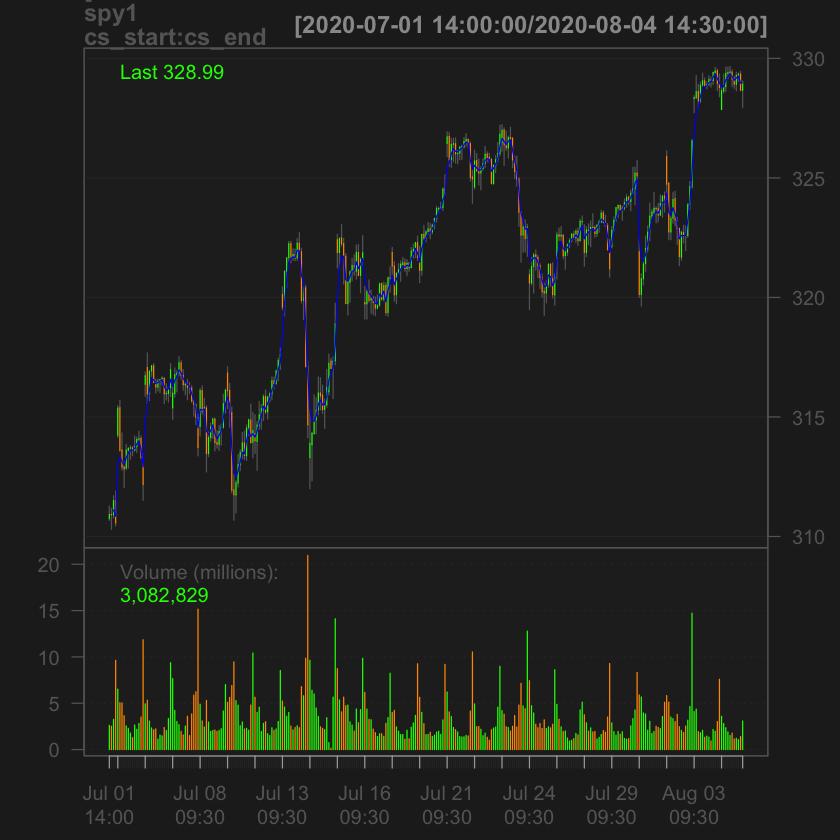

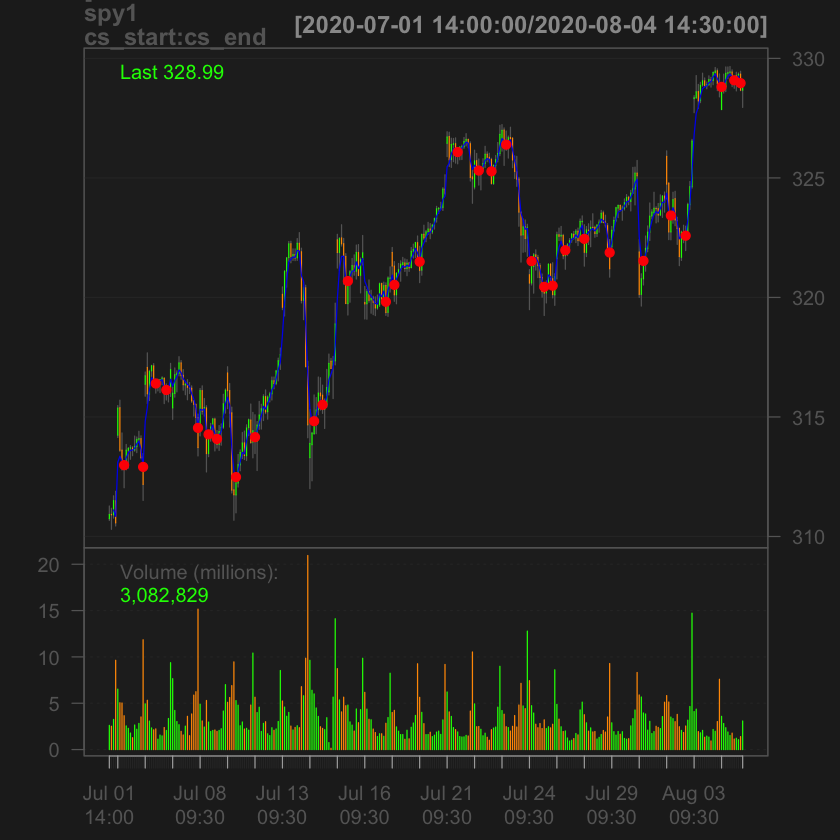

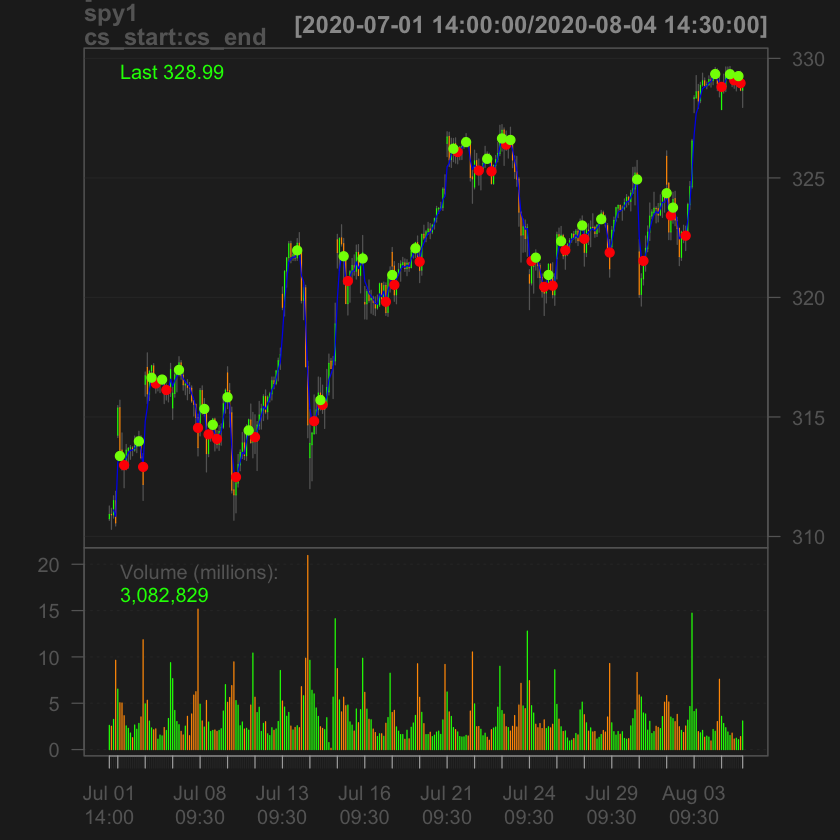

In [55]:
# Some extra chart samples

cs_idxs<-c(round(runif(5, min = 1, max = 47298-301)))
cs_idxs

cs_start=cs_idxs[1]
cs_end=cs_idxs[1]+300

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

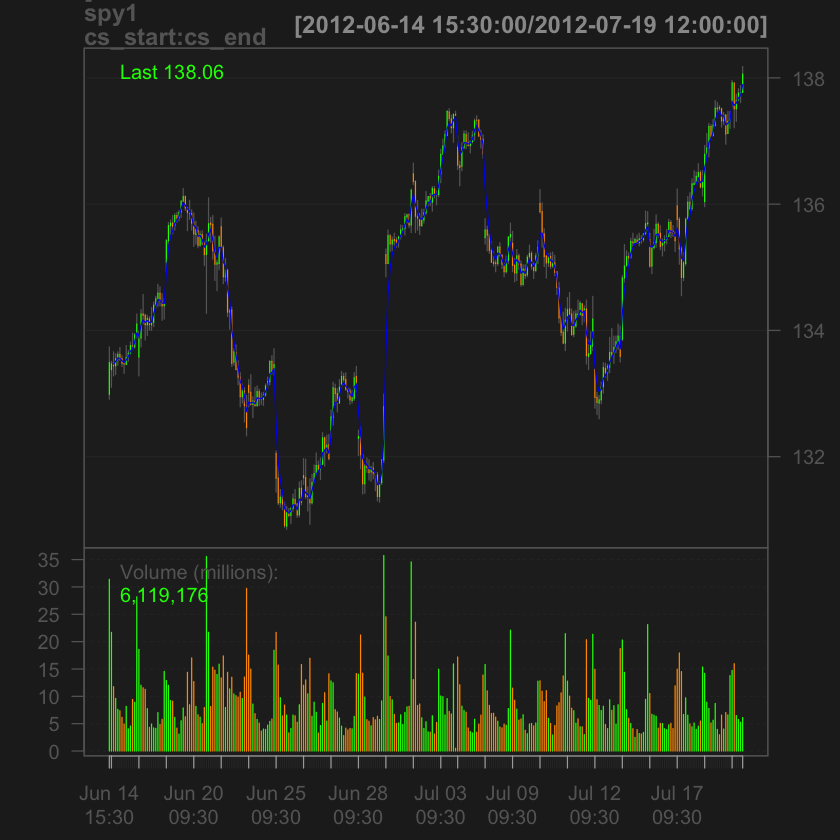

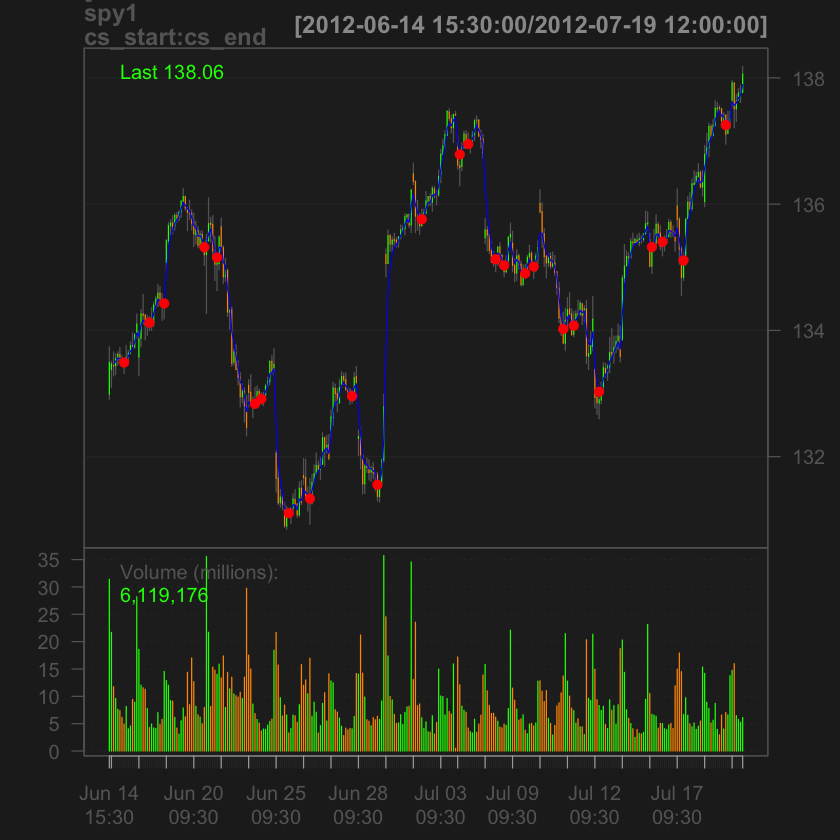

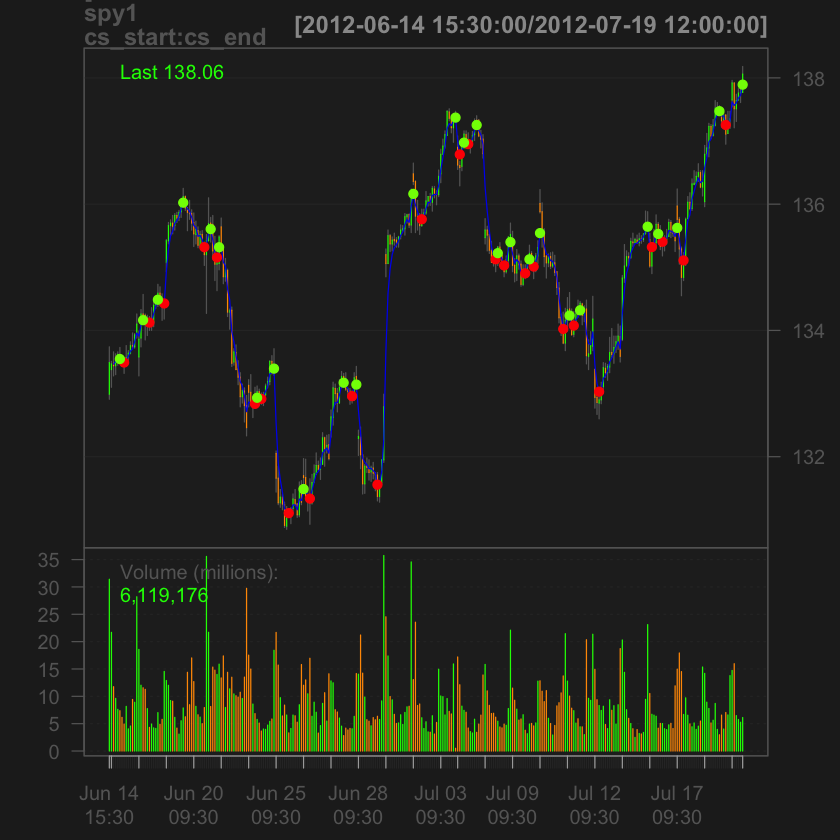

In [56]:
cs_start=cs_idxs[2]
cs_end=cs_idxs[2]+300

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

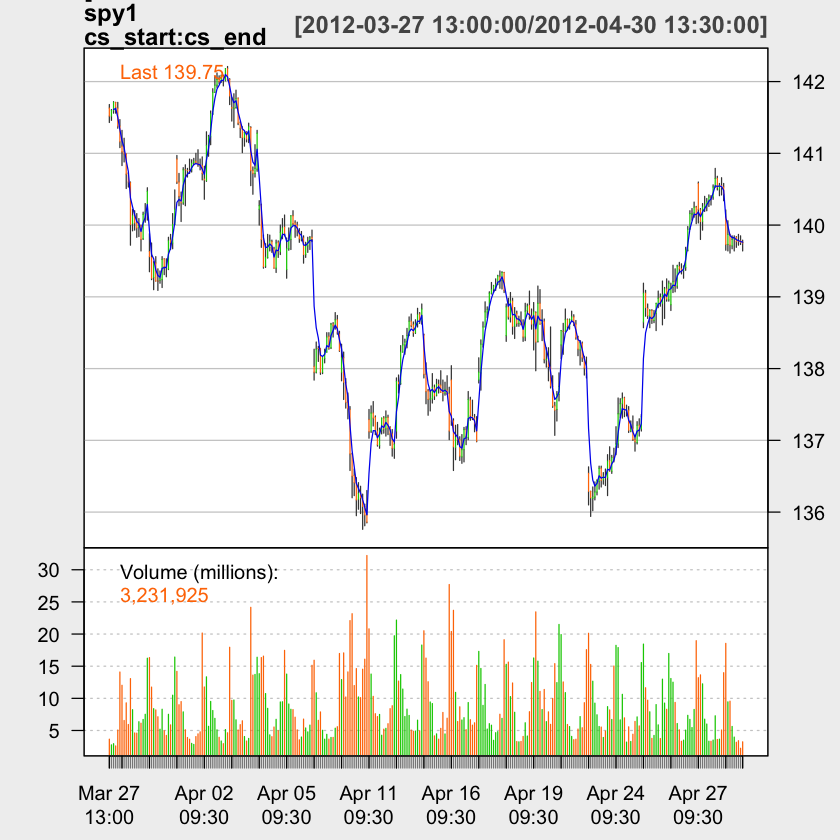

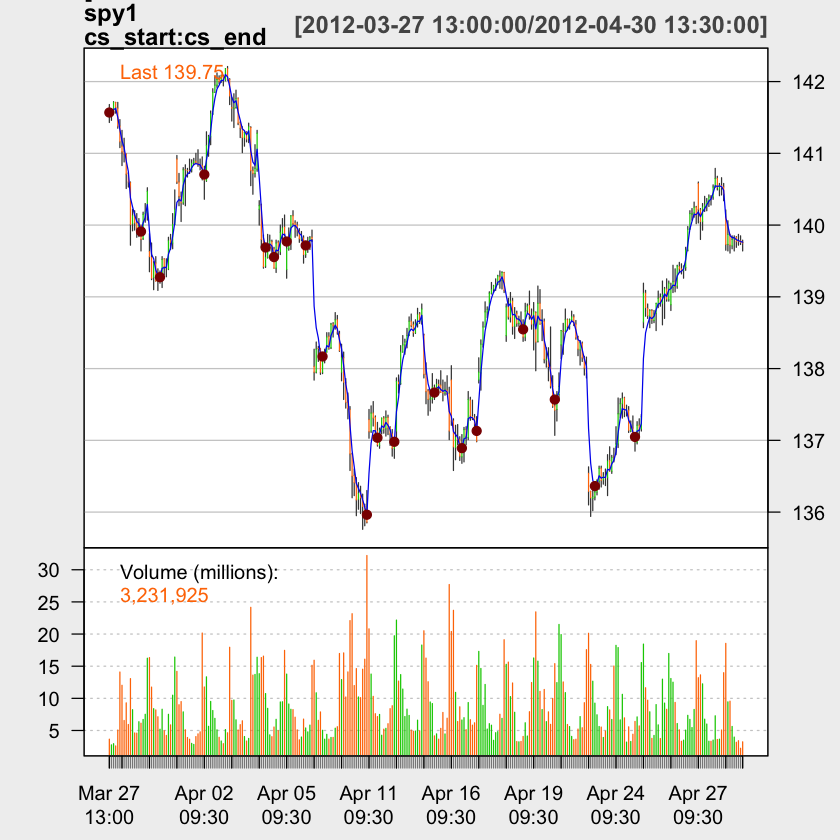

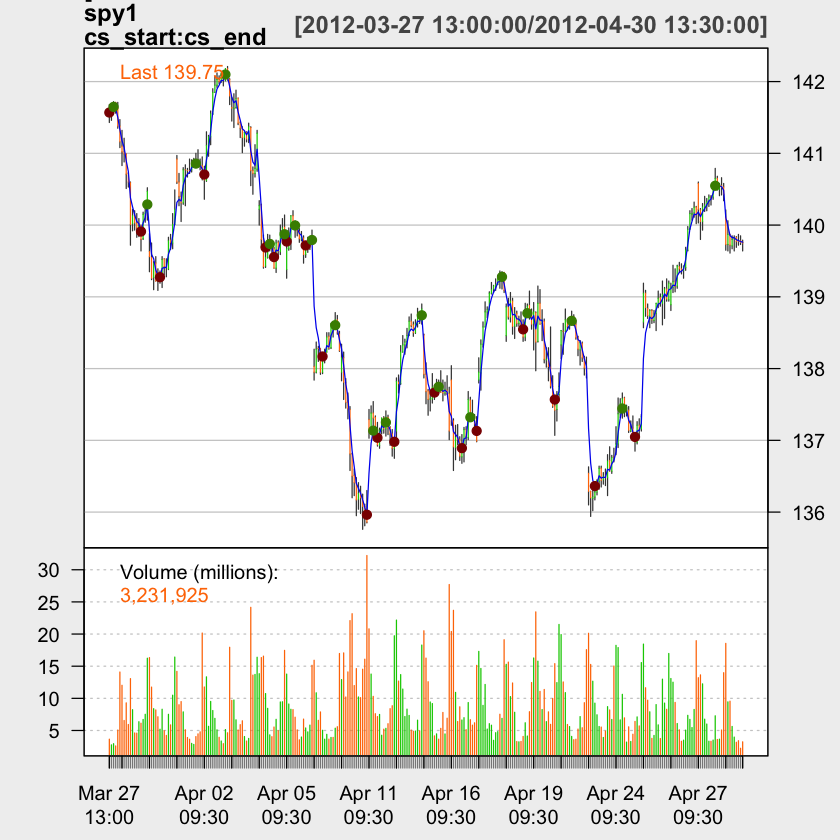

In [148]:
cs_start=cs_idxs[3]
cs_end=cs_idxs[3]+300

chartSeries(spy1[cs_start:cs_end,], theme='white',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red4', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse4', cex = 1.5)

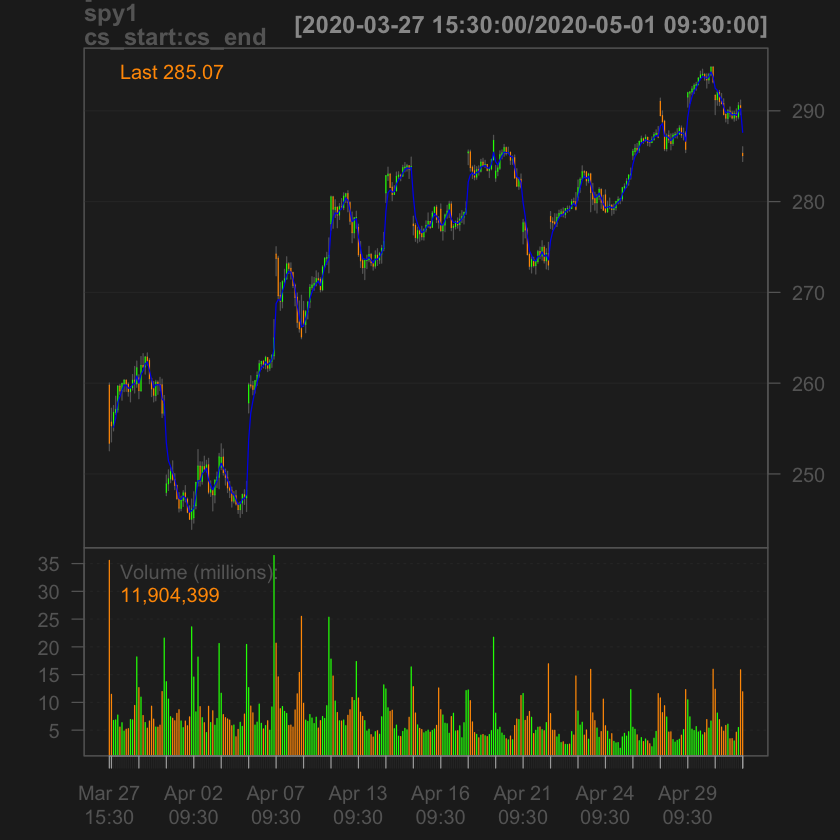

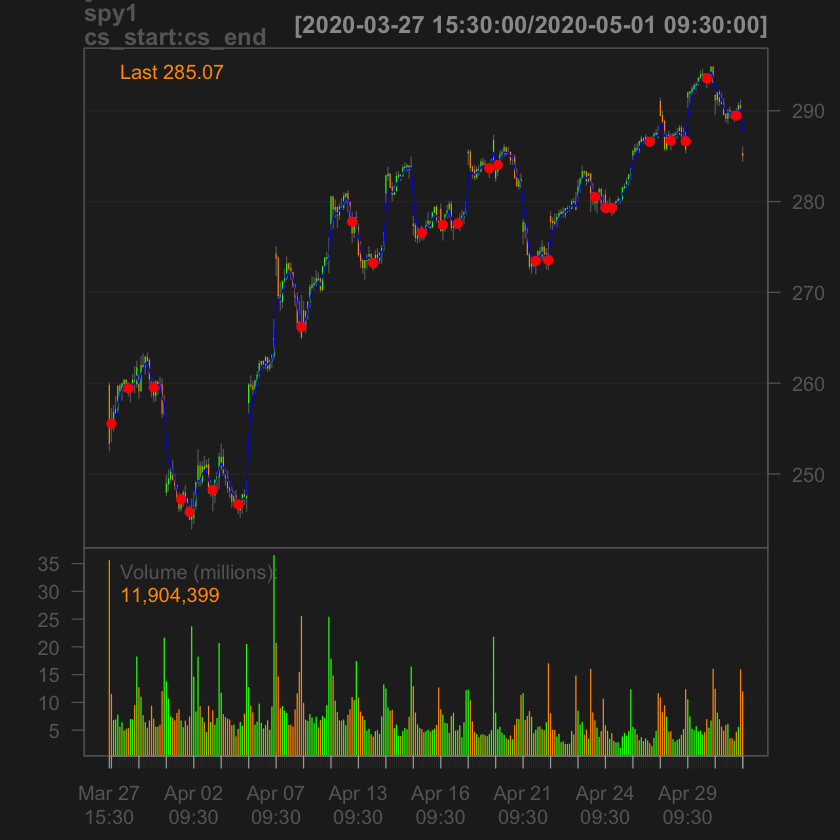

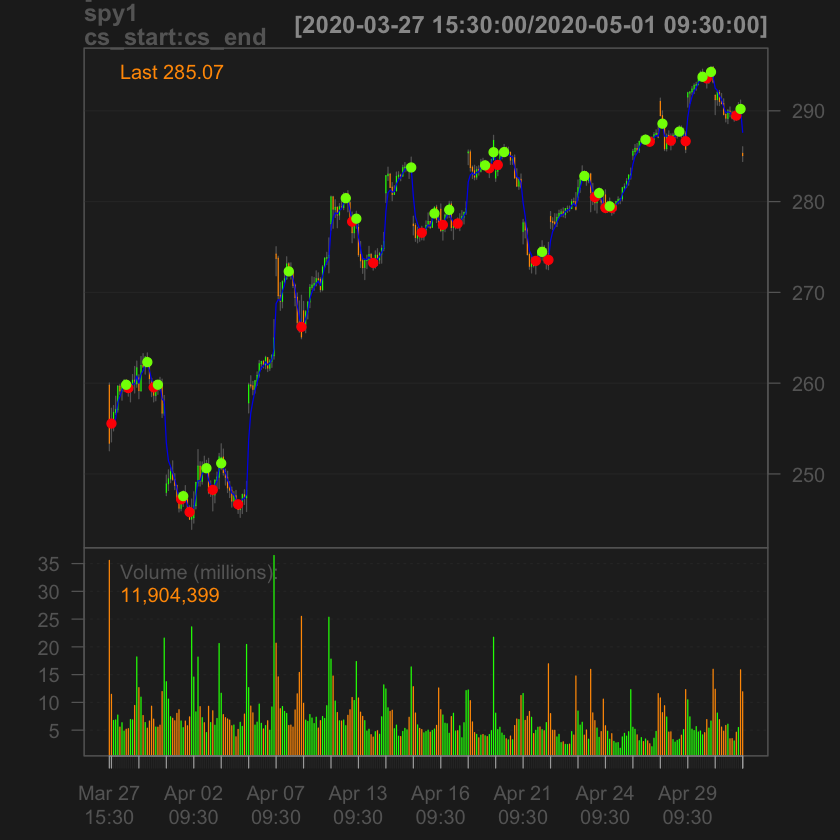

In [58]:
cs_start=cs_idxs[4]
cs_end=cs_idxs[4]+300

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

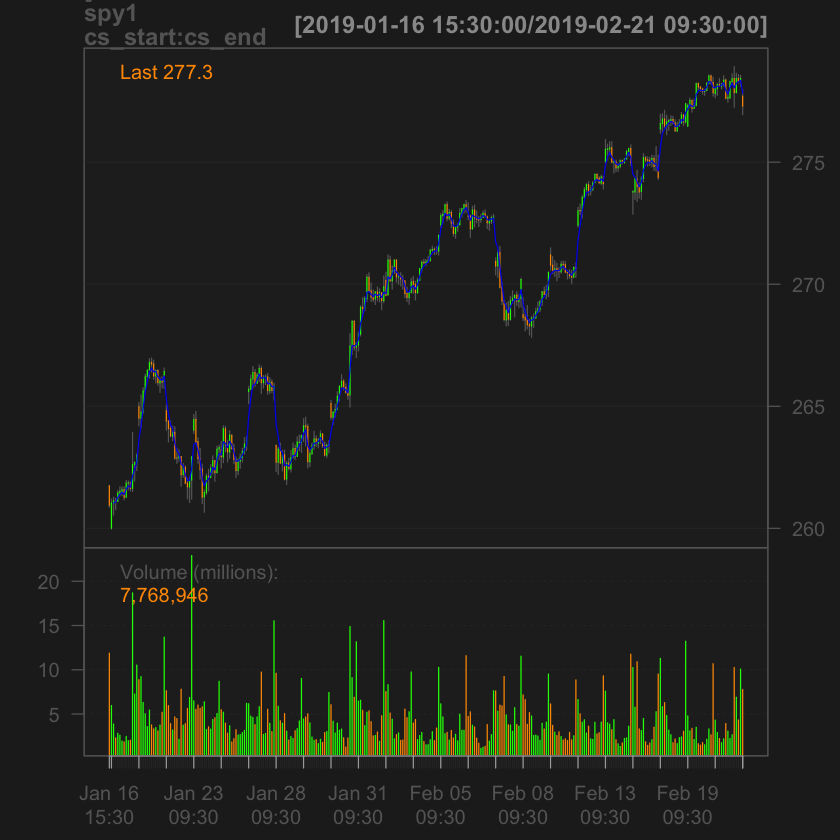

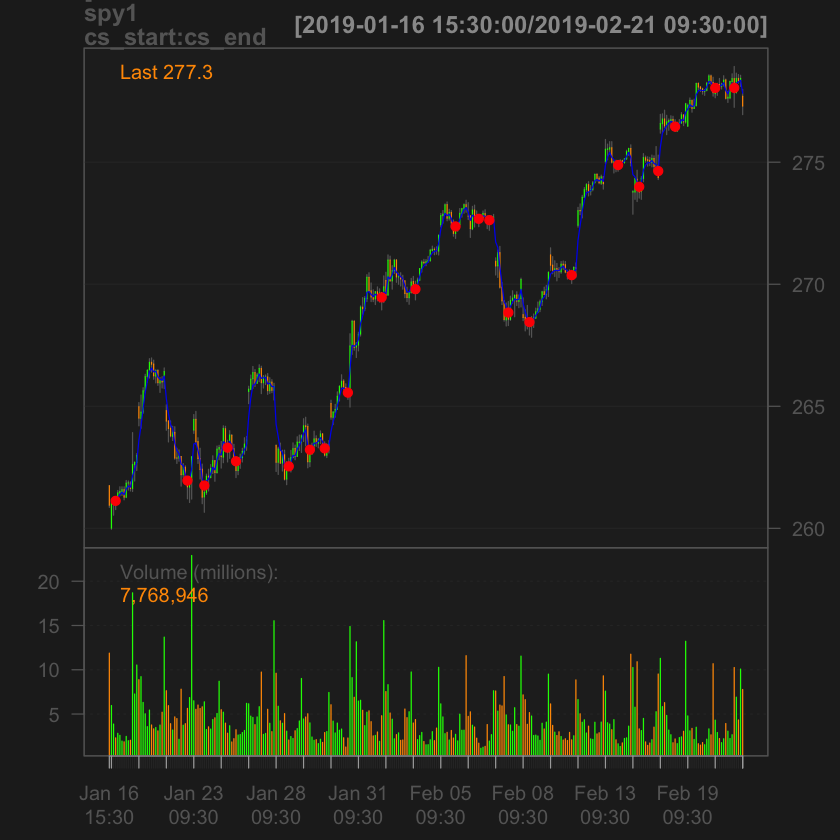

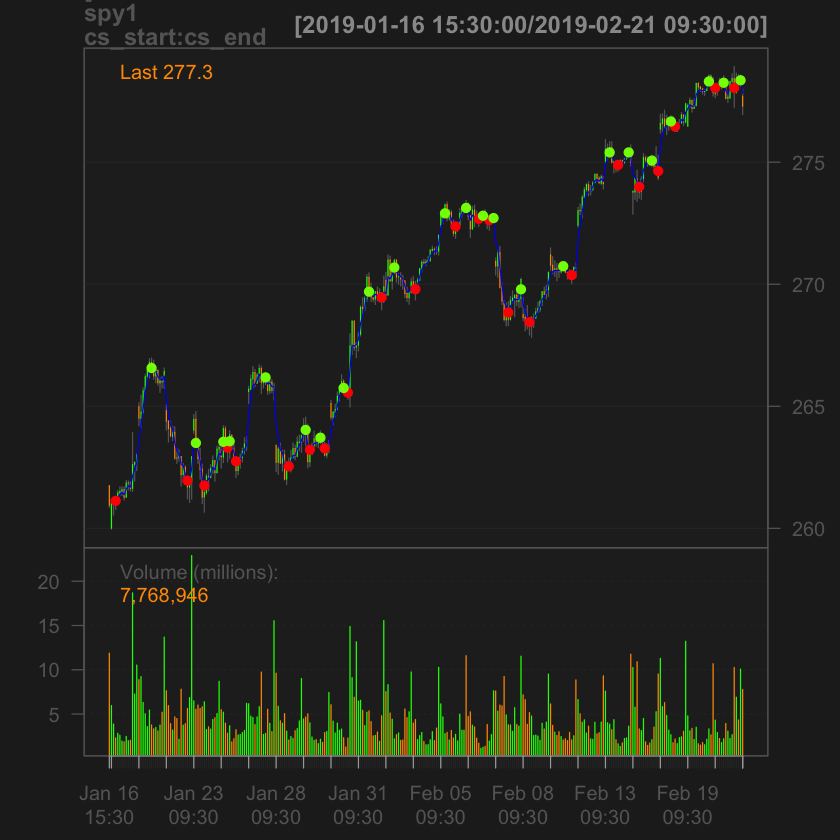

In [59]:
cs_start=cs_idxs[5]
cs_end=cs_idxs[5]+300

chartSeries(spy1[cs_start:cs_end,], theme='black',
            TA=c(addEMA(3, col='blue2'), addVo()))
addPoints(c(local_mins)-cs_start+1, spy_reversed[c(local_mins),'EMA3'], col='red1', cex = 1.5)
addPoints(c(local_maxs)-cs_start+1, spy_reversed[c(local_maxs),'EMA3'], col='chartreuse1', cex = 1.5)

In [ ]:
# Further implications of this project would be to code an algorithm using the TD Ameritrade API to read in
# current SPY price data and execute the trades.
# Also, constructing similar models and testing on different timeframes of candlestick such as 5-minute, 15-minute.
# Also, testing the models performance on individual stocks such as AAPl, TSLA.